In [ ]:
# Installing mlxtend package
!pip install mlxtend

In [1]:
# Import required Libraries

import pandas as pd
import numpy as np
from sklearn import preprocessing as sklearn_preprocessing
from sklearn.decomposition import PCA
#from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None



In [2]:
# Preprocess data

# Read price and security Data into Pandas dataframes.   
pricedf = pd.read_csv('prices.csv')
secdf = pd.read_csv('securities.csv')

# Inspect the dataframes and do some basic data cleaning

pricedf["date"] = pd.to_datetime(pricedf["date"]) 

secdf= secdf.drop(columns= ['SEC filings','Address of Headquarters','Date first added','CIK'])  

# See the first 5 rows of security and prices dataframe
print("First  5 rows of Security Data\n")
print(secdf.head()) 
print("\nFirst  5 rows of Price Data\n")
print (pricedf.head())      


First  5 rows of Security Data

  Ticker symbol             Security             GICS Sector  \
0           MMM           3M Company             Industrials   
1           ABT  Abbott Laboratories             Health Care   
2          ABBV               AbbVie             Health Care   
3           ACN        Accenture plc  Information Technology   
4          ATVI  Activision Blizzard  Information Technology   

                GICS Sub Industry  
0        Industrial Conglomerates  
1           Health Care Equipment  
2                 Pharmaceuticals  
3  IT Consulting & Other Services  
4     Home Entertainment Software  

First  5 rows of Price Data

        date symbol        open       close         low        high     volume
0 2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
1 2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2 2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
3 2016-01-08   WLTW  

In [3]:
# Analyse Sector Performance based on return 

industrydf = pricedf.merge(secdf,how='inner',left_on='symbol',right_on='Ticker symbol')
industrydf["1_day_return"]=industrydf["close"]/industrydf["close"].shift(1)
industrydf["trend"]=np.where(industrydf['1_day_return']<1 , -1,1)
industrydf=industrydf.dropna()
print("Print number of null values :" )
print (industrydf.isnull().sum())
ind_analysis = industrydf.groupby('GICS Sector').agg({'trend': ['sum']})
for col in ind_analysis.columns:
    print(col)
print("Sector wise Performance Report : \n")
print(ind_analysis)

# Based on the output of the above the top performming industry is Industrials followed by Consumer Discretionary
# and Information Technology

Print number of null values :
date                 0
symbol               0
open                 0
close                0
low                  0
high                 0
volume               0
Ticker symbol        0
Security             0
GICS Sector          0
GICS Sub Industry    0
1_day_return         0
trend                0
dtype: int64
('trend', 'sum')
Sector wise Performance Report : 

                            trend
                              sum
GICS Sector                      
Consumer Discretionary       5795
Consumer Staples             3498
Energy                        746
Financials                   5488
Health Care                  4850
Industrials                  5836
Information Technology       5672
Materials                    1726
Real Estate                  3608
Telecommunications Services   420
Utilities                    3126


In [4]:
#Filter MSFT prices from price data and store into a different dataframe

symboldf = pricedf[pricedf['symbol']=='MSFT']    
symboldf.reset_index(drop=True,inplace=True)

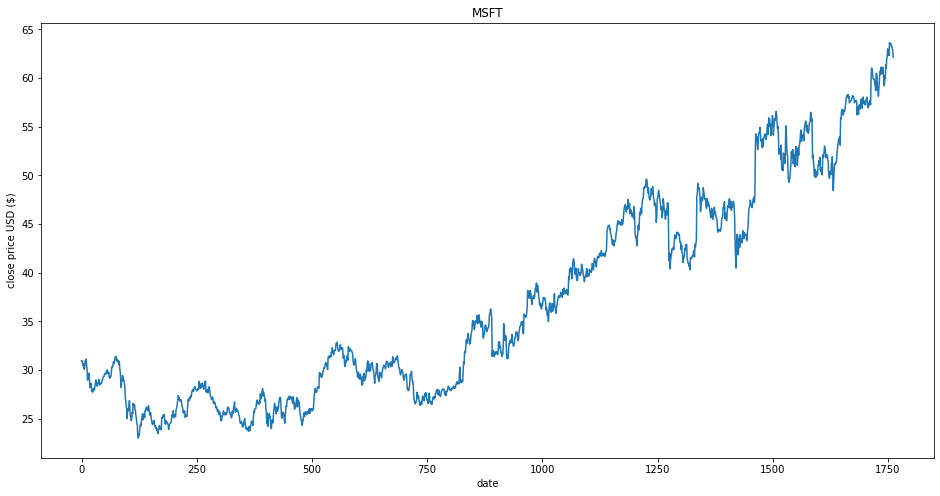

In [5]:
# Plot historical closing prices for MSFT

plt.figure(figsize = (16,8))
plt.title('MSFT')
plt.xlabel('date')
plt.ylabel('close price USD ($)')
plt.plot(symboldf['close'])
plt.show()  

In [6]:
#Print Relevant data for MSFT price 

print(symboldf.loc[1:5,"close"])    
print (type(symboldf))    
print(symboldf.head())    
print(symboldf.count())    
print(symboldf.describe())
print (symboldf.isnull().sum())

1    30.959999
2    30.770000
3    30.450001
4    30.660000
5    30.270000
Name: close, dtype: float64
<class 'pandas.core.frame.DataFrame'>
        date symbol       open      close        low       high      volume
0 2010-01-04   MSFT  30.620001  30.950001  30.590000  31.100000  38409100.0
1 2010-01-05   MSFT  30.850000  30.959999  30.639999  31.100000  49749600.0
2 2010-01-06   MSFT  30.879999  30.770000  30.520000  31.080000  58182400.0
3 2010-01-07   MSFT  30.629999  30.450001  30.190001  30.700001  50559700.0
4 2010-01-08   MSFT  30.280001  30.660000  30.240000  30.879999  51197400.0
date      1762
symbol    1762
open      1762
close     1762
low       1762
high      1762
volume    1762
dtype: int64
              open        close          low         high        volume
count  1762.000000  1762.000000  1762.000000  1762.000000  1.762000e+03
mean     37.110789    37.129841    36.788621    37.436754  4.579784e+07
std      10.796157    10.810695    10.725634    10.879890  2.428640e+

In [7]:
# Add Technical Indicator Attributes to the datframe

# References for Technical Indicators
# 1. Ma_50d - https://school.stockcharts.com/doku.php?id=technical_indicators:moving_averages 
# 2. macd_diff - https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd
# 3. Stochastic Oscillator - https://school.stockcharts.com/doku.php?id=technical_indicators:stochastic_oscillator_fast_slow_and_full
# 4. Commodity Channel Index (CCI) - https://school.stockcharts.com/doku.php?id=technical_indicators:commodity_channel_index_cci.
# 5. Bollinger Bands - https://school.stockcharts.com/doku.php?id=technical_indicators:bollinger_band_width
# 6. On Balance Volume - https://school.stockcharts.com/doku.php?id=technical_indicators:on_balance_volume_obv
# Return Indicators.
symboldf["1_day_return"]=symboldf["close"]/symboldf["close"].shift(1)
symboldf["close_to_open"]= symboldf["close"]/symboldf["open"]
symboldf["close_to_high"]=symboldf["close"]/symboldf["high"] 
symboldf["close_to_low"]=symboldf["close"]/symboldf["low"] 

# Trend Indicators
#
ema_12d = symboldf["close"].ewm(com=(12-1)/2).mean() ## 12 day EMA
ema_26d = symboldf["close"].ewm(com=(26-1)/2).mean() ## 26 day EMA
symboldf["macd_line"]= ema_12d - ema_26d
symboldf["macd_9d"]= symboldf["macd_line"].ewm(com=(9-1)/2).mean() ## 9 day EMA
symboldf["macd_diff"]= symboldf["macd_line"]-symboldf["macd_9d"]
symboldf["ma_50d"]= symboldf["close"].rolling(50).mean() 

# Momentum Indicators
k_period = 14
symboldf["stochastic_osci"]=((symboldf["close"] - symboldf["close"].rolling(k_period).min())/\
                             (symboldf["close"].rolling(k_period).max()-symboldf["close"].rolling(k_period).min()))*100

tp = (symboldf["high"]+symboldf["low"]+symboldf["close"])/3 
mean_dev = abs(tp - tp.rolling(20).mean()).rolling(20).mean()
symboldf["cci"] = (tp -tp.rolling(20).mean())/(0.015 * mean_dev)

symboldf["gnl"]=symboldf["close"].shift(1)-symboldf["close"]
avg_gain = symboldf["gnl"].iloc[:14][symboldf["gnl"].iloc[:14]> 0].sum()/ 14
avg_loss = abs(symboldf["gnl"].iloc[:14][symboldf["gnl"].iloc[:14]< 0].sum())/14
for i, row in symboldf.iloc[14:].iterrows():
    if row["gnl"] > 0:
        avg_gain = (avg_gain * 13 + row["gnl"])/ 14
    else:
        avg_loss = (avg_loss * 13 + abs(row["gnl"]))/ 14
    if avg_loss == 0:
        rs = 100
    else:
        rs = avg_gain/avg_loss
    symboldf.loc[i, "rsi"] = 100 - 100 / (1+ rs)

#Volatility Indicators
symboldf["5d_volatility"]=symboldf["1_day_return"].rolling(5).std()
symboldf["21d_volatility"]= symboldf["1_day_return"].rolling(21).std()
symboldf["60d_volatility"]=symboldf["1_day_return"].rolling(60).std()
symboldf["middle_band"] =(symboldf["close"].rolling(21).mean()) 
symboldf["upper_band"]=(symboldf["close"].rolling(21).mean() + 2 * symboldf["close"].rolling(21).std())
symboldf["lower_band"]=(symboldf["close"].rolling(21).mean() - 2 * symboldf["close"].rolling(21).std())
#symboldf["bollinger"] = ((symboldf["close"]-symboldf["close"].rolling(20).mean())/2* symboldf["close"].rolling(20).std())

# Volume Indicators
symboldf["volume_dif"]=symboldf["close"].shift(1) - symboldf["close"]
symboldf["on_balance_volume"] = symboldf["volume"]
symboldf["on_balance_volume"] =symboldf.apply(lambda row: row.volume * -1 if row.volume_dif < 0 else row.volume, axis = 1)
symboldf["on_balance_volume"] = symboldf["on_balance_volume"].cumsum()

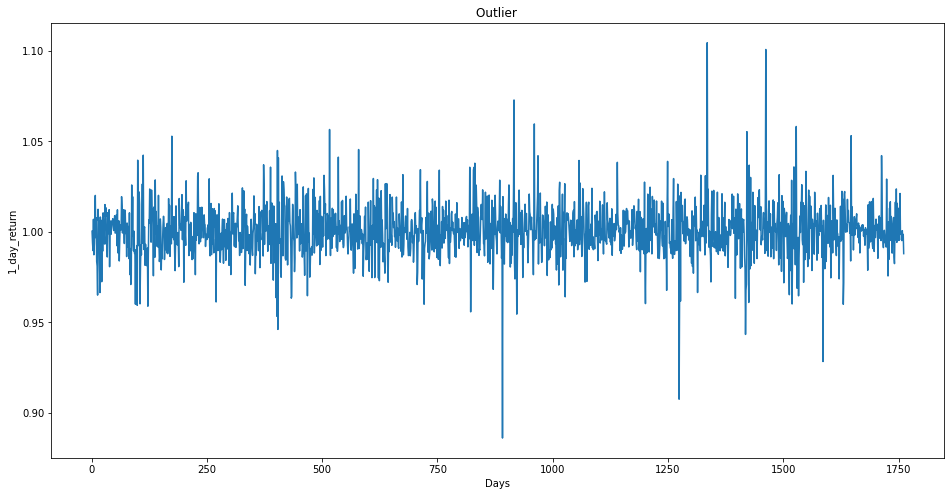

In [8]:
# Flag a row as a outlier or non outlier by adding a new column  
# Outliers are assesed for 1_day_return
# Note: Outliers will be removed only in training data after we split the dataset

def identify_outlier(row):
    """
    Identify if a row is outlier
    Args:
        row: pandas.DataFrame row
    Returns:
        1 or 0: Int     
    """
    x= row['1_day_return']
    mu=row['mean']
    sigma=row['std']
    if (x > mu + 3 * sigma)|(x < mu - 3 * sigma):
        return 1
    else:
        return 0


df_rolling =symboldf[['1_day_return']].rolling(window=21).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()  
symboldf_new=symboldf.join(df_rolling)
symboldf_new['outlier']=symboldf_new.apply(identify_outlier, axis = 1)
# Plot for outlier
plt.figure(figsize = (16,8))
plt.axes().set_title('Outlier ')
plt.xlabel('Days')
plt.ylabel('1_day_return')
plt.plot(symboldf['1_day_return'])
plt.show() 

In [9]:
## Remove temporary columns and null values

symboldf_new=symboldf_new.drop(['macd_line','macd_9d','gnl','volume_dif','mean','std'],axis=1)
symboldf_new=symboldf_new.dropna()
symboldf_new.reset_index(drop=True,inplace=True)

In [10]:
# Add Class Attribute(trend column) based on 1_day_return  
# The industry practice for stock market trend is to indicate whether a market is going up or down(buy or sell).
# The trend column(class attribute) will have either of two values: 
# a)  1 if 1 day return is up 
# b) -1 if return is down 
# To be consistent with practicioner's approach,the class attribute is not categorised further(eg:Likert scale)

symboldf_new["trend"]=np.where(symboldf_new['1_day_return']<1 , -1,1)


In [11]:
# Inspect your modified data(outlier flag,technical indicators,class attribute etc)

print("The structure of the modified symboldf dataframe is : ")
print(symboldf_new.describe())
print("The first five rows of the modified symboldf dataframe is : ")
print(symboldf_new.head())

The structure of the modified symboldf dataframe is : 
              open        close          low         high        volume  \
count  1702.000000  1702.000000  1702.000000  1702.000000  1.702000e+03   
mean     37.386839    37.407497    37.063860    37.715335  4.536722e+07   
std      10.881174    10.894907    10.809333    10.965249  2.414583e+07   
min      23.090000    23.010000    22.730000    23.320000  8.409600e+06   
25%      27.650000    27.657500    27.332500    27.925000  2.920020e+07   
50%      33.910000    33.974998    33.609999    34.305000  4.008585e+07   
75%      46.317500    46.410000    45.945001    46.799999  5.461425e+07   
max      63.840000    63.619999    63.410000    64.099998  3.193179e+08   

       1_day_return  close_to_open  close_to_high  close_to_low    macd_diff  \
count   1702.000000    1702.000000    1702.000000   1702.000000  1702.000000   
mean       1.000540       1.000534       0.991723      1.009387     0.001435   
std        0.014703       0.0

Total No of up_trend: 863
Total No of down_trend: 839


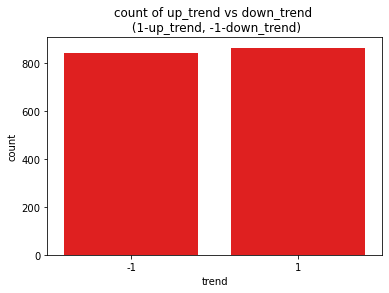

In [12]:
# Check if data is balanced

up_trend=len(symboldf_new[symboldf_new.trend==1])
print('Total No of up_trend:', up_trend)
down_trend=len(symboldf_new[symboldf_new.trend==-1])
print('Total No of down_trend:', down_trend)
# Based on above data is balanced(UPTREND = 852, DOWN TREND = 839)

# Visualise the balanced dataset
sns.countplot(x='trend', data=symboldf_new, color = 'red')
plt.axes().set_title('count of up_trend vs down_trend \n (1-up_trend, -1-down_trend)')
plt.show()

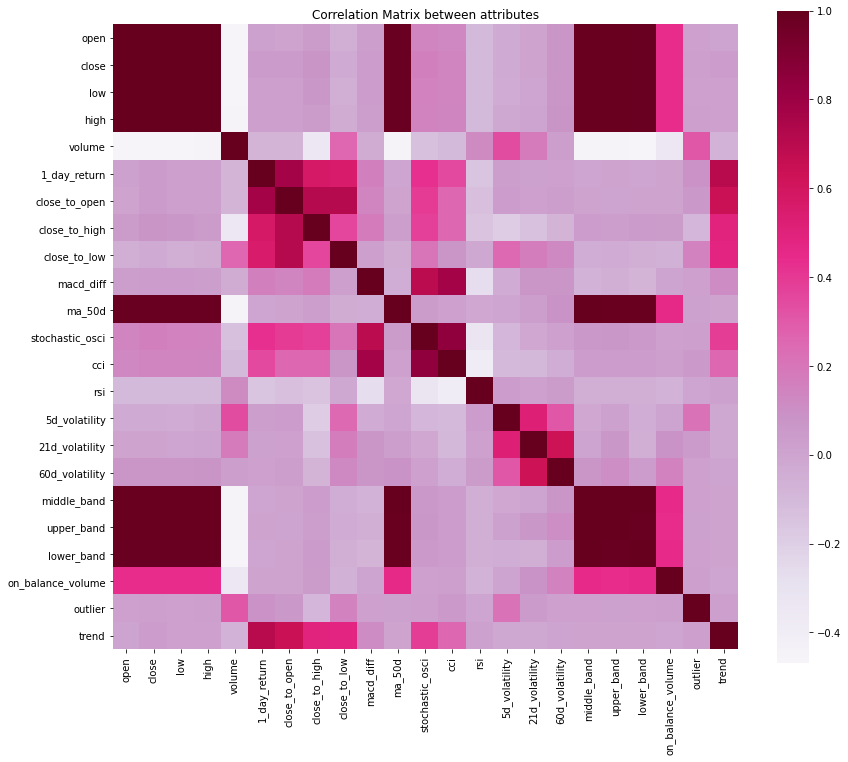

In [13]:
## Correlation Analysis
cor=symboldf_new.corr(method = 'pearson')
fig=plt.figure(figsize=(14,12))
ax=plt.axes()
sns.heatmap(cor, square=True, vmax=1,cmap="PuRd",ax = ax)
ax.set_title('Correlation Matrix between attributes')
plt.show()

#  The data is normally distributed (1_day_return/trend -  dependent value).
#  We used Pearson correlation for our analysis.  
#  Most of the attributes are calculated from the '1_day_return' column and therefore show high correlation between columns. 
#  In order to determine an attribute strength, we perfom feature selection techiniques.

<Figure size 432x288 with 0 Axes>

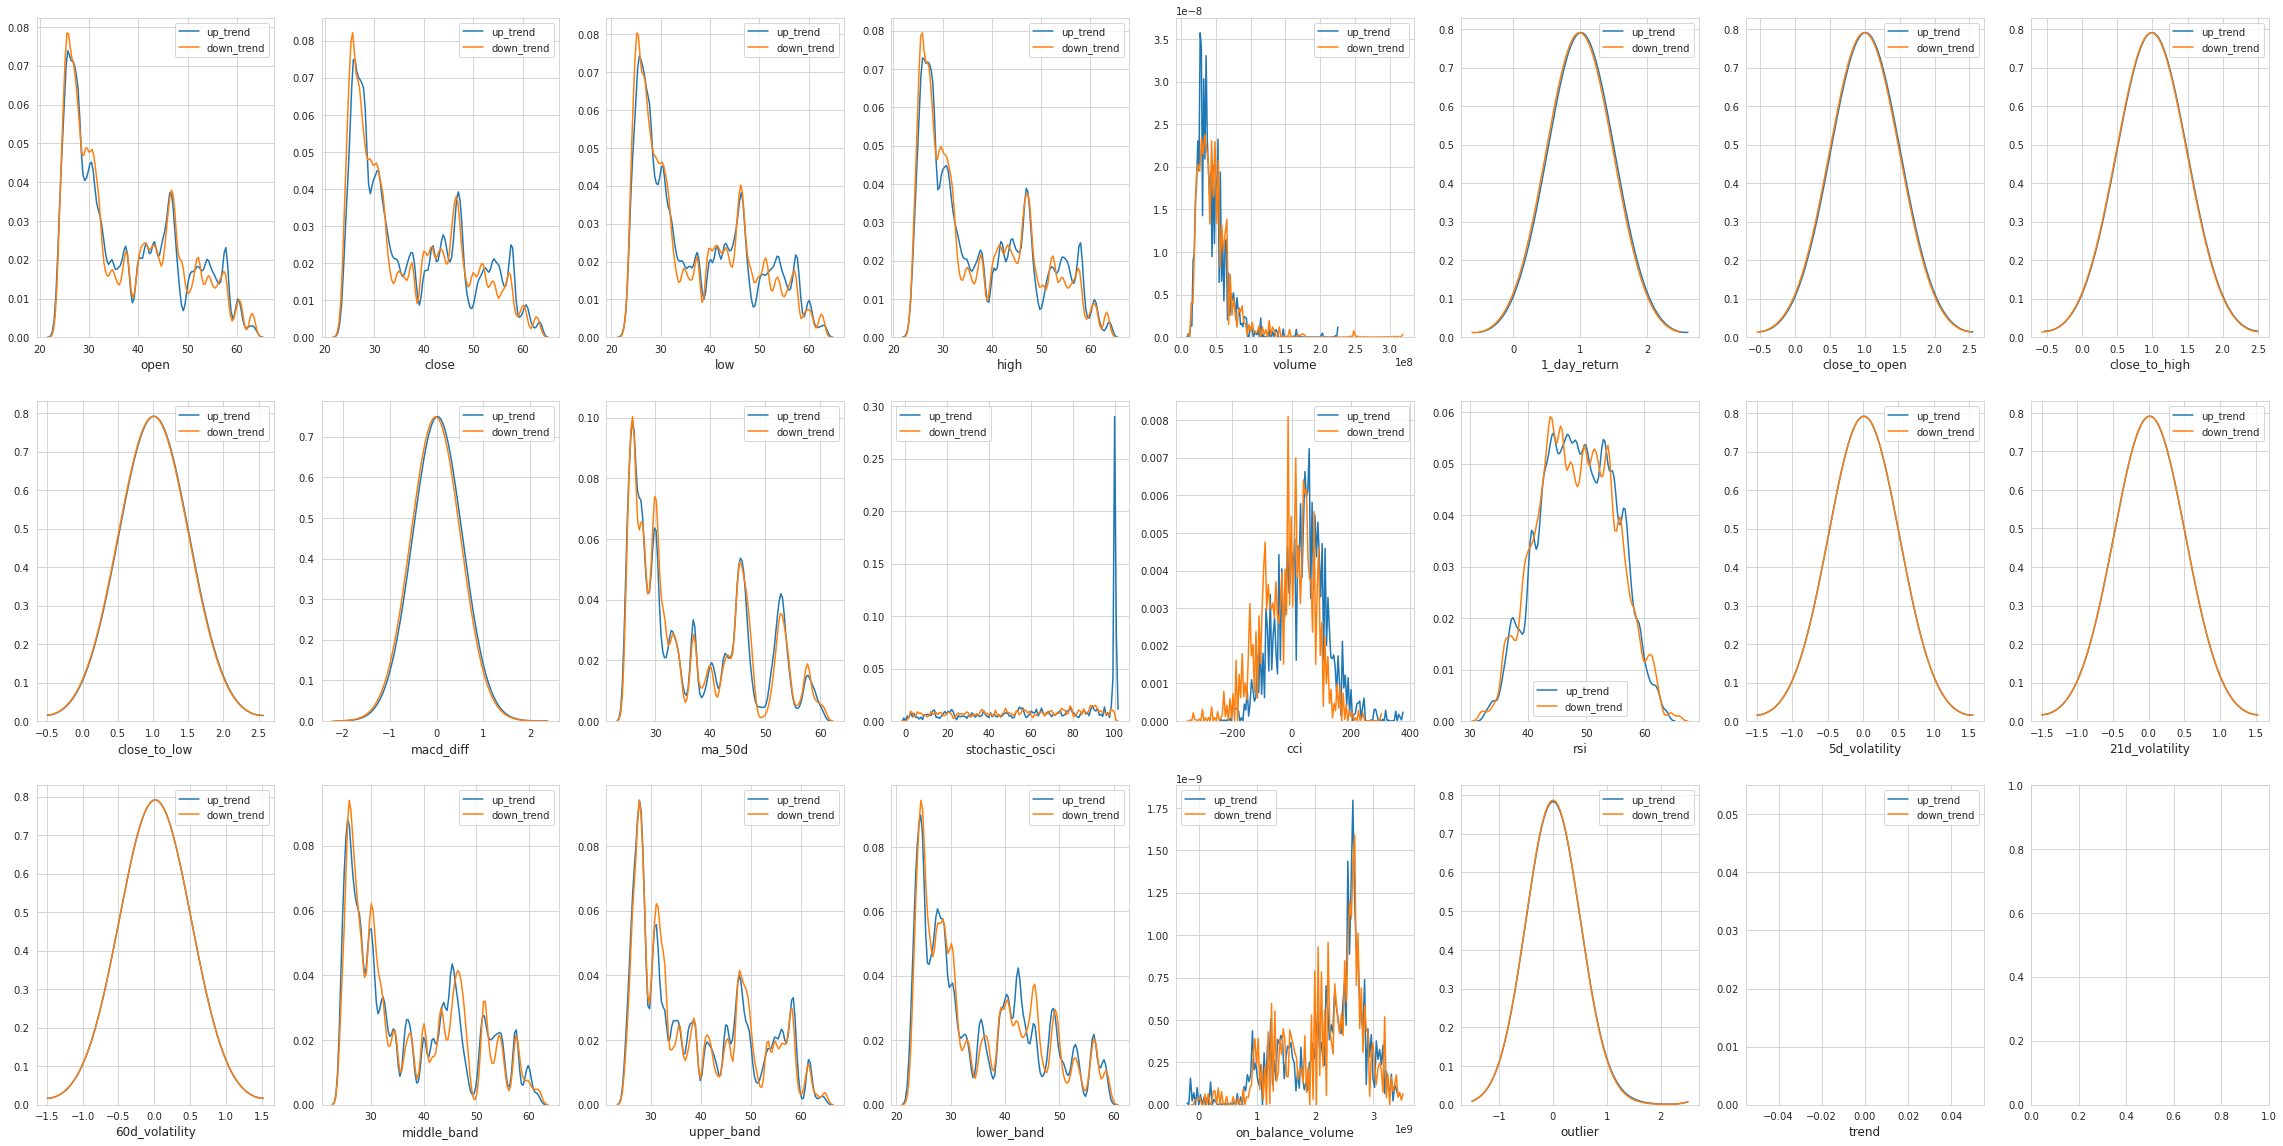

In [14]:
# Plot the distribution for all features using histogram

col_distribution=symboldf_new.columns.values
i=0
up_loc=symboldf_new.loc[symboldf_new.trend==1]
down_loc=symboldf_new.loc[symboldf_new.trend==-1]
    
sns.set_style('whitegrid')
fig=plt.figure()
fig.ax=plt.subplots(3,8,figsize=(40,20))
    
for attributes in col_distribution:
    if(attributes=='date' or attributes=='symbol'):
        continue
    i+=1
    plt.subplot(3,8,i)
    sns.kdeplot(up_loc[attributes], bw=0.5, label ='up_trend')
    sns.kdeplot(down_loc[attributes], bw=0.5, label='down_trend')
    plt.xlabel(attributes, fontsize=12)
    locs,labels=plt.xticks()
    plt.tick_params(axis ='both',which='major')
plt.show()

# Target attributes (1_day_return or trend) shows normal distribution
# Technical indicator columns are derived from 1_day_return.
# Outliers are identified and removed on training data set.

In [53]:
# Create test and training dataset
# Reuse these data sets for subsequent steps if possible(with slight transformation)
# The below code snippet is run multiple times(10X) in order to train and test the models with different combinations
# The average of the model output(accuracy,precision,recall,F1-Score,ROC AUC score) were manually computed.

x = symboldf_new[['open','close','low','high','volume','close_to_open', 'close_to_high',\
                  'close_to_low', 'macd_diff', 'ma_50d','stochastic_osci', 'cci','rsi',\
                  '5d_volatility','21d_volatility','60d_volatility','middle_band',\
                  'upper_band','lower_band','on_balance_volume','outlier']]
y = symboldf_new[['trend','outlier']]

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.7)

#Remove outliers from training data set
x_train=x_train[x_train['outlier']!=1] 
y_train=y_train[y_train['outlier']!=1] 
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

## Remove the outlier flag(column) as it is no longer required
x_train=x_train.drop(['outlier'], axis = 1)
y_train=y_train.drop(['outlier'], axis = 1)
x_test=x_test.drop(['outlier'], axis = 1)
y_test=y_test.drop(['outlier'], axis = 1)

print('Total no of transaction in training data set:',len(x_train))
print('Total No of Transaction in testing data set:', len(x_test))
print("\n the first 5 rows in training dataset is : ")
print(x_train.head())

Total no of transaction in training data set: 1182
Total No of Transaction in testing data set: 511

 the first 5 rows in training dataset is : 
        open      close        low       high      volume  close_to_open  \
0  24.440001  24.280001  24.240000  24.639999  51643000.0       0.993453   
1  57.110001  57.110001  56.400002  57.270000  22177500.0       1.000000   
2  54.990002  55.349998  54.500000  55.480000  28322200.0       1.006547   
3  46.849998  47.349998  46.419998  47.680000  29928300.0       1.010672   
4  37.939999  37.980000  37.860001  38.349998  38021300.0       1.001054   

   close_to_high  close_to_low  macd_diff   ma_50d  stochastic_osci  \
0       0.985390      1.001650  -0.116218  25.1102         3.333400   
1       0.997206      1.012589  -0.042646  57.5520        18.420981   
2       0.997657      1.015596  -0.173446  53.2026        62.318696   
3       0.993079      1.020034  -0.069863  43.5154        68.900309   
4       0.990352      1.003170   0.133150  

Result for Mutual Information classification method : 

['close_to_open', 'close_to_high', 'stochastic_osci', 'close_to_low', 'cci', 'close', 'on_balance_volume', 'middle_band', 'upper_band', 'low']
close_to_open        0.310230
close_to_high        0.193960
stochastic_osci      0.189494
close_to_low         0.147036
cci                  0.040930
close                0.024701
on_balance_volume    0.016753
middle_band          0.016563
upper_band           0.015573
low                  0.006136
rsi                  0.003583
macd_diff            0.001005
volume               0.000120
high                 0.000000
ma_50d               0.000000
lower_band           0.000000
5d_volatility        0.000000
21d_volatility       0.000000
60d_volatility       0.000000
open                 0.000000
dtype: float64


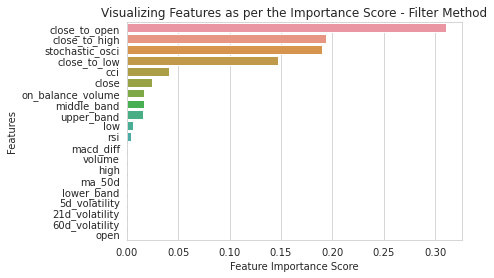

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.2s finished

[2020-12-05 02:52:04] Features: 1/12 -- score: 0.7631298671552909[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   10.9s finished

[2020-12-05 02:52:15] Features: 2/12 -- score: 0.8637797755382501[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   10.7s finished

[2020-12-05 02:52:26] Features: 3/12 -- score: 0.8739263628034815[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   11.1s finished

[2020-12-05 02:52:37] Features: 4/12 -- score: 0.8730846312414109[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    9.7s finished



Result of Forward Selection method  : 

['volume', 'close_to_open', 'close_to_low', 'macd_diff', 'stochastic_osci', 'cci', 'rsi', '5d_volatility', '21d_volatility', 'middle_band', 'upper_band', 'on_balance_volume']
<class 'tuple'>
(4, 5, 7, 8, 10, 11, 12, 13, 14, 16, 17, 19)
0.875627004122767


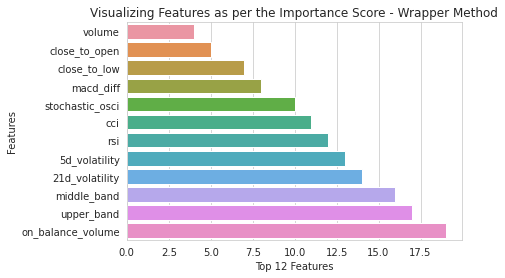

Result for Embedded method : 

['on_balance_volume', '60d_volatility', '21d_volatility', '5d_volatility', 'volume', 'macd_diff', 'rsi', 'cci', 'close_to_low', 'stochastic_osci', 'close_to_high', 'close_to_open']
             Features  Importances
0                open     0.014457
2                 low     0.014876
16        middle_band     0.015161
17         upper_band     0.015239
3                high     0.015796
1               close     0.016720
9              ma_50d     0.016827
18         lower_band     0.016879
19  on_balance_volume     0.020620
15     60d_volatility     0.022441
14     21d_volatility     0.022613
13      5d_volatility     0.026514
4              volume     0.027391
8           macd_diff     0.029743
12                rsi     0.034687
11                cci     0.037013
7        close_to_low     0.106782
10    stochastic_osci     0.117852
6       close_to_high     0.140853
5       close_to_open     0.287536


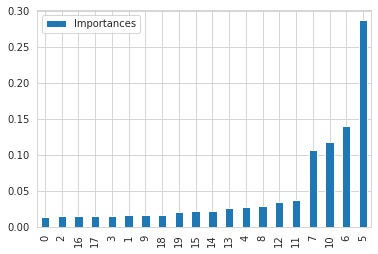

In [54]:
# Feature Selection Techniques
# The following three methods are used to extract features and the model performance is evaluated seperately
# with each of these methods

# 1. Filter method - Mutual Info Classification
x_train_fm=x_train.copy()
y_train_fm=y_train.copy()
mi = mutual_info_classif(x_train_fm,y_train_fm)
mi = pd.Series(mi)
mi.index=x_train_fm.columns
mi.sort_values(ascending = False, inplace = True)
print("Result for Mutual Information classification method : \n")
mi_columns=mi.keys().tolist()[0:10]
print(mi_columns)
print(mi)

#Vizualising  Feature Importance Score
sns.barplot(x= mi,y=mi.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.axes().set_title("Visualizing Features as per the Importance Score - Filter Method")
plt.show()

# 2. Wrapper method - Forward selection
x_train_wm=x_train.copy()
y_train_wm=y_train.copy()
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state = 0, n_jobs=-1),
          k_features = 12,
          forward = True,
          floating = False,
          verbose = 2,
          scoring = 'accuracy',
          cv = 4,
          n_jobs = -1
          ).fit(x_train_wm,y_train_wm)
print("Result of Forward Selection method  : \n")
fwd_sel_columns=list(sfs.k_feature_names_)
print(fwd_sel_columns)
print(type(sfs.k_feature_names_))
print(sfs.k_feature_idx_)
print(sfs.k_score_)

#Vizualising Feature Importance Score
sns.barplot(x=sfs.k_feature_idx_, y=fwd_sel_columns)
plt.xlabel('Top 12 Features')
plt.ylabel('Features')
plt.axes().set_title("Visualizing Features as per the Importance Score - Wrapper Method")
plt.show()

# 3. Embedded method - Tree based
x_train_em=x_train.copy()
y_train_em=y_train.copy()
model =RandomForestClassifier(n_estimators = 340)
model.fit(x_train, y_train)
    
# importance of the resulting features
importances = model.feature_importances_
    
# dataframe for vizualisation
df1=pd.DataFrame({"Features":x_train.columns, "Importances":importances})
df1.set_index('Importances')    

df1=df1.sort_values('Importances')
print("Result for Embedded method : \n")
tree_sel_columns=df1['Features'].tail(12).tolist()
print(tree_sel_columns)
print(df1)
df1.plot.bar()

ROC AUC score: 0.9201216522645095

Accuracy for Random Forest information gain feature selection is: 0.8590998043052838

Classification report:
               precision    recall  f1-score   support

          -1       0.85      0.87      0.86       252
           1       0.87      0.85      0.86       259

    accuracy                           0.86       511
   macro avg       0.86      0.86      0.86       511
weighted avg       0.86      0.86      0.86       511



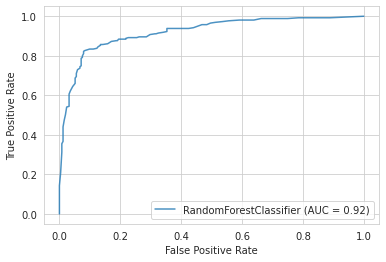

In [55]:
# Build Ml Models

# 1. Random Forest Models

# Note: In the below code,the  Random forest model is run with and without feature selection
# For the model run with feature selection,three different feature selection techniques are used
# and the results evaluated. The outputs have indicated that Wrapper technique produced better 
# accuracy when average of the 10 runs were taken


# Model-1.a With feature selection-Filter Technique(Mutual Information).
# Extract only the columns selected by filter technique

x_train_rf = x_train[mi_columns]
x_test_rf =  x_test[mi_columns]

# RandomForest classifier
random_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = 'gini', random_state = 10)
random_frst_clf.fit(x_train_rf, y_train)
y_pred = random_frst_clf.predict(x_test_rf)

# Predict probabilities for each class
prob = random_frst_clf.predict_proba(x_test_rf)

# Plot ROC curve
rfc_disp_curve=plot_roc_curve(random_frst_clf,x_test_rf,y_test,alpha = 0.8)

# Calculate ROC AUC score using selected features
print('ROC AUC score:', roc_auc_score(y_test, prob[:,1]))

# Calculate accuracy score for selected features
print('\nAccuracy for Random Forest information gain feature selection is:',accuracy_score(y_test,y_pred))

# Print the classification report of the dataset using the selected features
print('\nClassification report:\n',classification_report(y_test,y_pred))

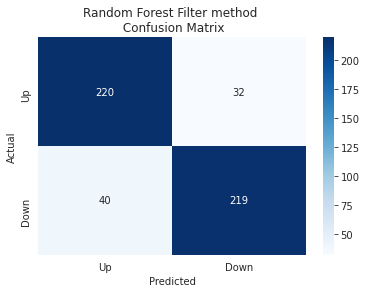

In [56]:
# Confusion Matrix
rf_cfm =confusion_matrix(y_test, y_pred)
sns.heatmap(rf_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Random Forest Filter method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [57]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_rf = TimeSeriesSplit(n_splits = 5)
scores_rf = cross_val_score(RandomForestClassifier(),x_train_rf, y_train, scoring = 'accuracy', cv = tscv_rf )
print('Cross validation score for RF using 5 Fold Split:',scores_rf)
print("Mean Accuracy from Cross Validation for 5 Fold Split: ",scores_rf.mean())

# 10 Fold
tscv_rf = TimeSeriesSplit(n_splits = 10)
scores_rf = cross_val_score(RandomForestClassifier(),x_train_rf, y_train, scoring = 'accuracy', cv = tscv_rf )
print('\nCross validation score for RF using 10 Fold Split:',scores_rf)
print("Mean Accuracy from Cross Validation for 10 Fold Split: ",scores_rf.mean())

Cross validation score for RF using 5 Fold Split: [0.81725888 0.89847716 0.89340102 0.8680203  0.81725888]
Mean Accuracy from Cross Validation for 5 Fold Split:  0.8588832487309646

Cross validation score for RF using 10 Fold Split: [0.77570093 0.86915888 0.8317757  0.92523364 0.92523364 0.87850467
 0.87850467 0.85981308 0.81308411 0.8317757 ]
Mean Accuracy from Cross Validation for 10 Fold Split:  0.8588785046728973


ROC AUC score: 0.9350907029478458

Accuracy for Random Forest wrapper feature selection is: 0.8649706457925636
Classification report:
               precision    recall  f1-score   support

          -1       0.86      0.86      0.86       252
           1       0.87      0.87      0.87       259

    accuracy                           0.86       511
   macro avg       0.86      0.86      0.86       511
weighted avg       0.86      0.86      0.86       511



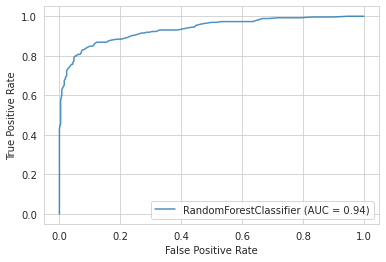

In [58]:
# Model-1.b Random forest with Wrapper method (Forward feature selection)

x_train_rf1 = x_train[fwd_sel_columns]
x_test_rf1 =  x_test[fwd_sel_columns]

# RandomForest classifier
random_frst_clf1 = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = 'gini', random_state = 2)
random_frst_clf1.fit(x_train_rf1, y_train)

y_pred1 = random_frst_clf1.predict(x_test_rf1)

#Predict probabilities for each class
prob1 = random_frst_clf1.predict_proba(x_test_rf1)

#Plot the ROC curve
rfc_disp_curve=plot_roc_curve(random_frst_clf1,x_test_rf1,y_test,alpha = 0.8)

# Calculate ROC AUC score using selected features
print('ROC AUC score:', roc_auc_score(y_test, prob1[:,1]))

# Calculate accuracy score for selected features
print('\nAccuracy for Random Forest wrapper feature selection is:',accuracy_score(y_test,y_pred1))

# Print the classification report of the dataset using the selected feature 
print('Classification report:\n',classification_report(y_test,y_pred1))


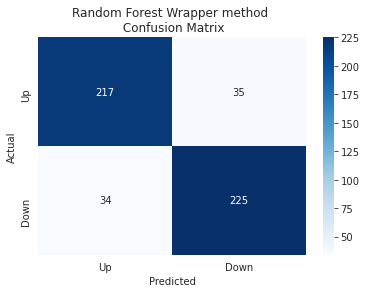

In [59]:
# Confusion Matrix
rf1_cfm =confusion_matrix(y_test, y_pred1)
sns.heatmap(rf1_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Random Forest Wrapper method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [60]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_rf1 = TimeSeriesSplit(n_splits = 5)
scores_rf1= cross_val_score(RandomForestClassifier(),x_train_rf1, y_train, scoring = 'accuracy', cv = tscv_rf1)
print('Cross validation score for RF using 5 Fold Split:',scores_rf1)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_rf1.mean())

# 10 Fold
tscv_rf1 = TimeSeriesSplit(n_splits = 10)
scores_rf1 = cross_val_score(RandomForestClassifier(),x_train_rf1, y_train, scoring = 'accuracy', cv = tscv_rf1 )
print('\nCross validation score for RF using 10 Fold Split:',scores_rf1)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_rf1.mean())

Cross validation score for RF using 5 Fold Split: [0.83756345 0.90862944 0.89340102 0.88324873 0.83248731]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8710659898477158

Cross validation score for RF using 10 Fold Split: [0.81308411 0.8411215  0.86915888 0.92523364 0.91588785 0.90654206
 0.86915888 0.87850467 0.81308411 0.8411215 ]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8672897196261683


ROC AUC score: 0.9280581602010173

Accuracy for Random Forest  Tree Based feature selection is: 0.8669275929549902
Classification report:
               precision    recall  f1-score   support

          -1       0.87      0.87      0.87       252
           1       0.87      0.87      0.87       259

    accuracy                           0.87       511
   macro avg       0.87      0.87      0.87       511
weighted avg       0.87      0.87      0.87       511



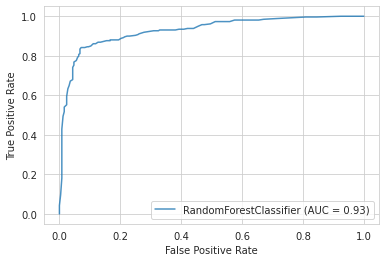

In [61]:
# Model-1.c Random Forest With Embedded method (Tree based feature selection attributes)

x_train_rf2 = x_train[tree_sel_columns]
x_test_rf2 = x_test[tree_sel_columns]

# RandomForest classifier
random_frst_clf2 = RandomForestClassifier(n_estimators =100, oob_score = True, criterion = 'gini', random_state = 100)
random_frst_clf2.fit(x_train_rf2, y_train)
y_pred2 = random_frst_clf2.predict(x_test_rf2)

# Predict probabilities for each class
prob2 = random_frst_clf2.predict_proba(x_test_rf2)

# Plot the ROC curve
rfc_disp_curve=plot_roc_curve(random_frst_clf2, x_test_rf2, y_test, alpha = 0.8)

# Calculate ROC AUC score using selected features
print('ROC AUC score:', roc_auc_score(y_test, prob2[:,1]))

# Calculate accuracy score for selected features
print('\nAccuracy for Random Forest  Tree Based feature selection is:',accuracy_score(y_test, y_pred2))

## Print the classification report of the dataset using the selected feature 
print('Classification report:\n',classification_report(y_test, y_pred2))


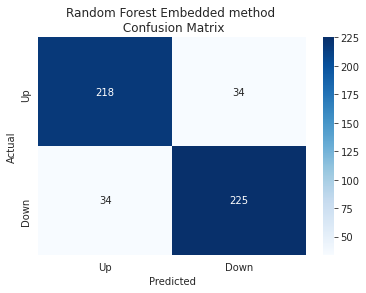

In [62]:
# Confusion Matrix
rf2_cfm =confusion_matrix(y_test, y_pred2)
sns.heatmap(rf2_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Random Forest Embedded method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [63]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_rf2 = TimeSeriesSplit(n_splits = 5)
scores_rf2= cross_val_score(RandomForestClassifier(),x_train_rf2, y_train, scoring = 'accuracy', cv = tscv_rf2)
print('Cross validation score for RF using 5 Fold Split:',scores_rf2)
print('Mean Accuracy from Cross Validation for 5 Fold Split:', scores_rf2.mean())

#10 Fold
tscv_rf2 = TimeSeriesSplit(n_splits = 10)
scores_rf2 = cross_val_score(RandomForestClassifier(),x_train_rf2, y_train, scoring = 'accuracy', cv = tscv_rf2 )
print('\nCross validation score for RF using 10 Fold Split:',scores_rf2)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_rf2.mean())

Cross validation score for RF using 5 Fold Split: [0.83248731 0.91370558 0.8680203  0.88324873 0.82741117]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8649746192893402

Cross validation score for RF using 10 Fold Split: [0.81308411 0.82242991 0.8411215  0.91588785 0.91588785 0.88785047
 0.87850467 0.86915888 0.81308411 0.85046729]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8607476635514019


ROC AUC score: 0.9159465588037017

Accuracy for Random Forest without feature selection is: 0.8493150684931506

Classification report:
               precision    recall  f1-score   support

          -1       0.84      0.86      0.85       252
           1       0.86      0.84      0.85       259

    accuracy                           0.85       511
   macro avg       0.85      0.85      0.85       511
weighted avg       0.85      0.85      0.85       511



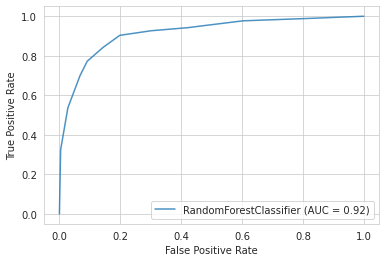

In [64]:
# Model-1.d Random forest Model without feature selection 

x_train_rf3 = x_train[['open','close','low','high','ma_50d','middle_band','upper_band','lower_band','close_to_open',\
                       'close_to_high','close_to_low', 'volume', 'macd_diff','stochastic_osci', 'cci', 'rsi', '5d_volatility',\
                       '21d_volatility', '60d_volatility', 'on_balance_volume']]
x_test_rf3 = x_test[['open','close','low','high','ma_50d','middle_band','upper_band','lower_band','close_to_open',\
                     'close_to_high','close_to_low', 'volume', 'macd_diff','stochastic_osci', 'cci', 'rsi', '5d_volatility',\
                     '21d_volatility', '60d_volatility', 'on_balance_volume']]

# RandomForest classifier
random_frst_clf3 = RandomForestClassifier(n_estimators = 10, oob_score = True, criterion = 'gini',random_state = 1)
random_frst_clf3.fit(x_train_rf3, y_train)

y_pred3 = random_frst_clf3.predict(x_test_rf3)

# predict probabilities for each class
prob3 = random_frst_clf3.predict_proba(x_test_rf3)

# plot the roc curve
rfc_disp_curve=plot_roc_curve(random_frst_clf3, x_test_rf3, y_test, alpha = 0.8)

# Calculate R0C AUC score using selected features
print('ROC AUC score:', roc_auc_score(y_test, prob3[:,1]))

# Calculate accuracy score for selected features
print('\nAccuracy for Random Forest without feature selection is:',accuracy_score(y_test, y_pred3))

## Print the classification report of the dataset using the selected feature only
print('\nClassification report:\n',classification_report(y_test, y_pred3))



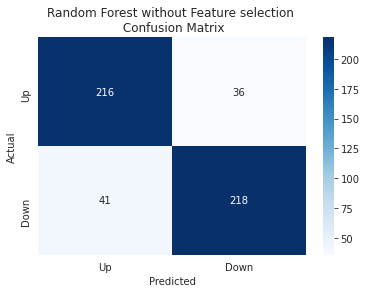

In [65]:
# Confusion Matrix
rf3_cfm =confusion_matrix(y_test, y_pred3)
sns.heatmap(rf3_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Random Forest without Feature selection \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [66]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_rf3 = TimeSeriesSplit(n_splits = 5)
scores_rf3= cross_val_score(RandomForestClassifier(),x_train_rf3, y_train, scoring = 'accuracy', cv = tscv_rf3)
print('Cross validation score for RF using 5 Fold Split:',scores_rf3)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_rf3.mean())

#10 Fold
tscv_rf3 = TimeSeriesSplit(n_splits = 10)
scores_rf3 = cross_val_score(RandomForestClassifier(),x_train_rf3, y_train, scoring = 'accuracy', cv = tscv_rf3 )
print('\nCross validation score for RF using 10 Fold Split:',scores_rf3)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_rf3.mean())

Cross validation score for RF using 5 Fold Split: [0.82233503 0.90862944 0.90862944 0.88832487 0.81725888]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8690355329949238

Cross validation score for RF using 10 Fold Split: [0.79439252 0.82242991 0.81308411 0.91588785 0.91588785 0.87850467
 0.88785047 0.85981308 0.82242991 0.8317757 ]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8542056074766355


|--- feature_1 <= 1.00
|   |--- feature_4 <= 99.86
|   |   |--- feature_1 <= 1.00
|   |   |   |--- feature_4 <= 0.70
|   |   |   |   |--- class: -1
|   |   |   |--- feature_4 >  0.70
|   |   |   |   |--- feature_3 <= -0.08
|   |   |   |   |   |--- feature_9 <= 26.02
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_9 >  26.02
|   |   |   |   |   |   |--- feature_1 <= 1.00
|   |   |   |   |   |   |   |--- feature_3 <= -0.09
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |   |--- feature_3 >  -0.09
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |--- feature_1 >  1.00
|   |   |   |   |   |   |   |--- feature_4 <= 7.49
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_4 >  7.49
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |--- feature_3 >  -0.08
|   |   |   |   |   |--- feature_4 <= 93.68
|   |   |   |   |   |   |--- feature_2 <= 1.02
|   |   |   |   |   |   |   |--- 

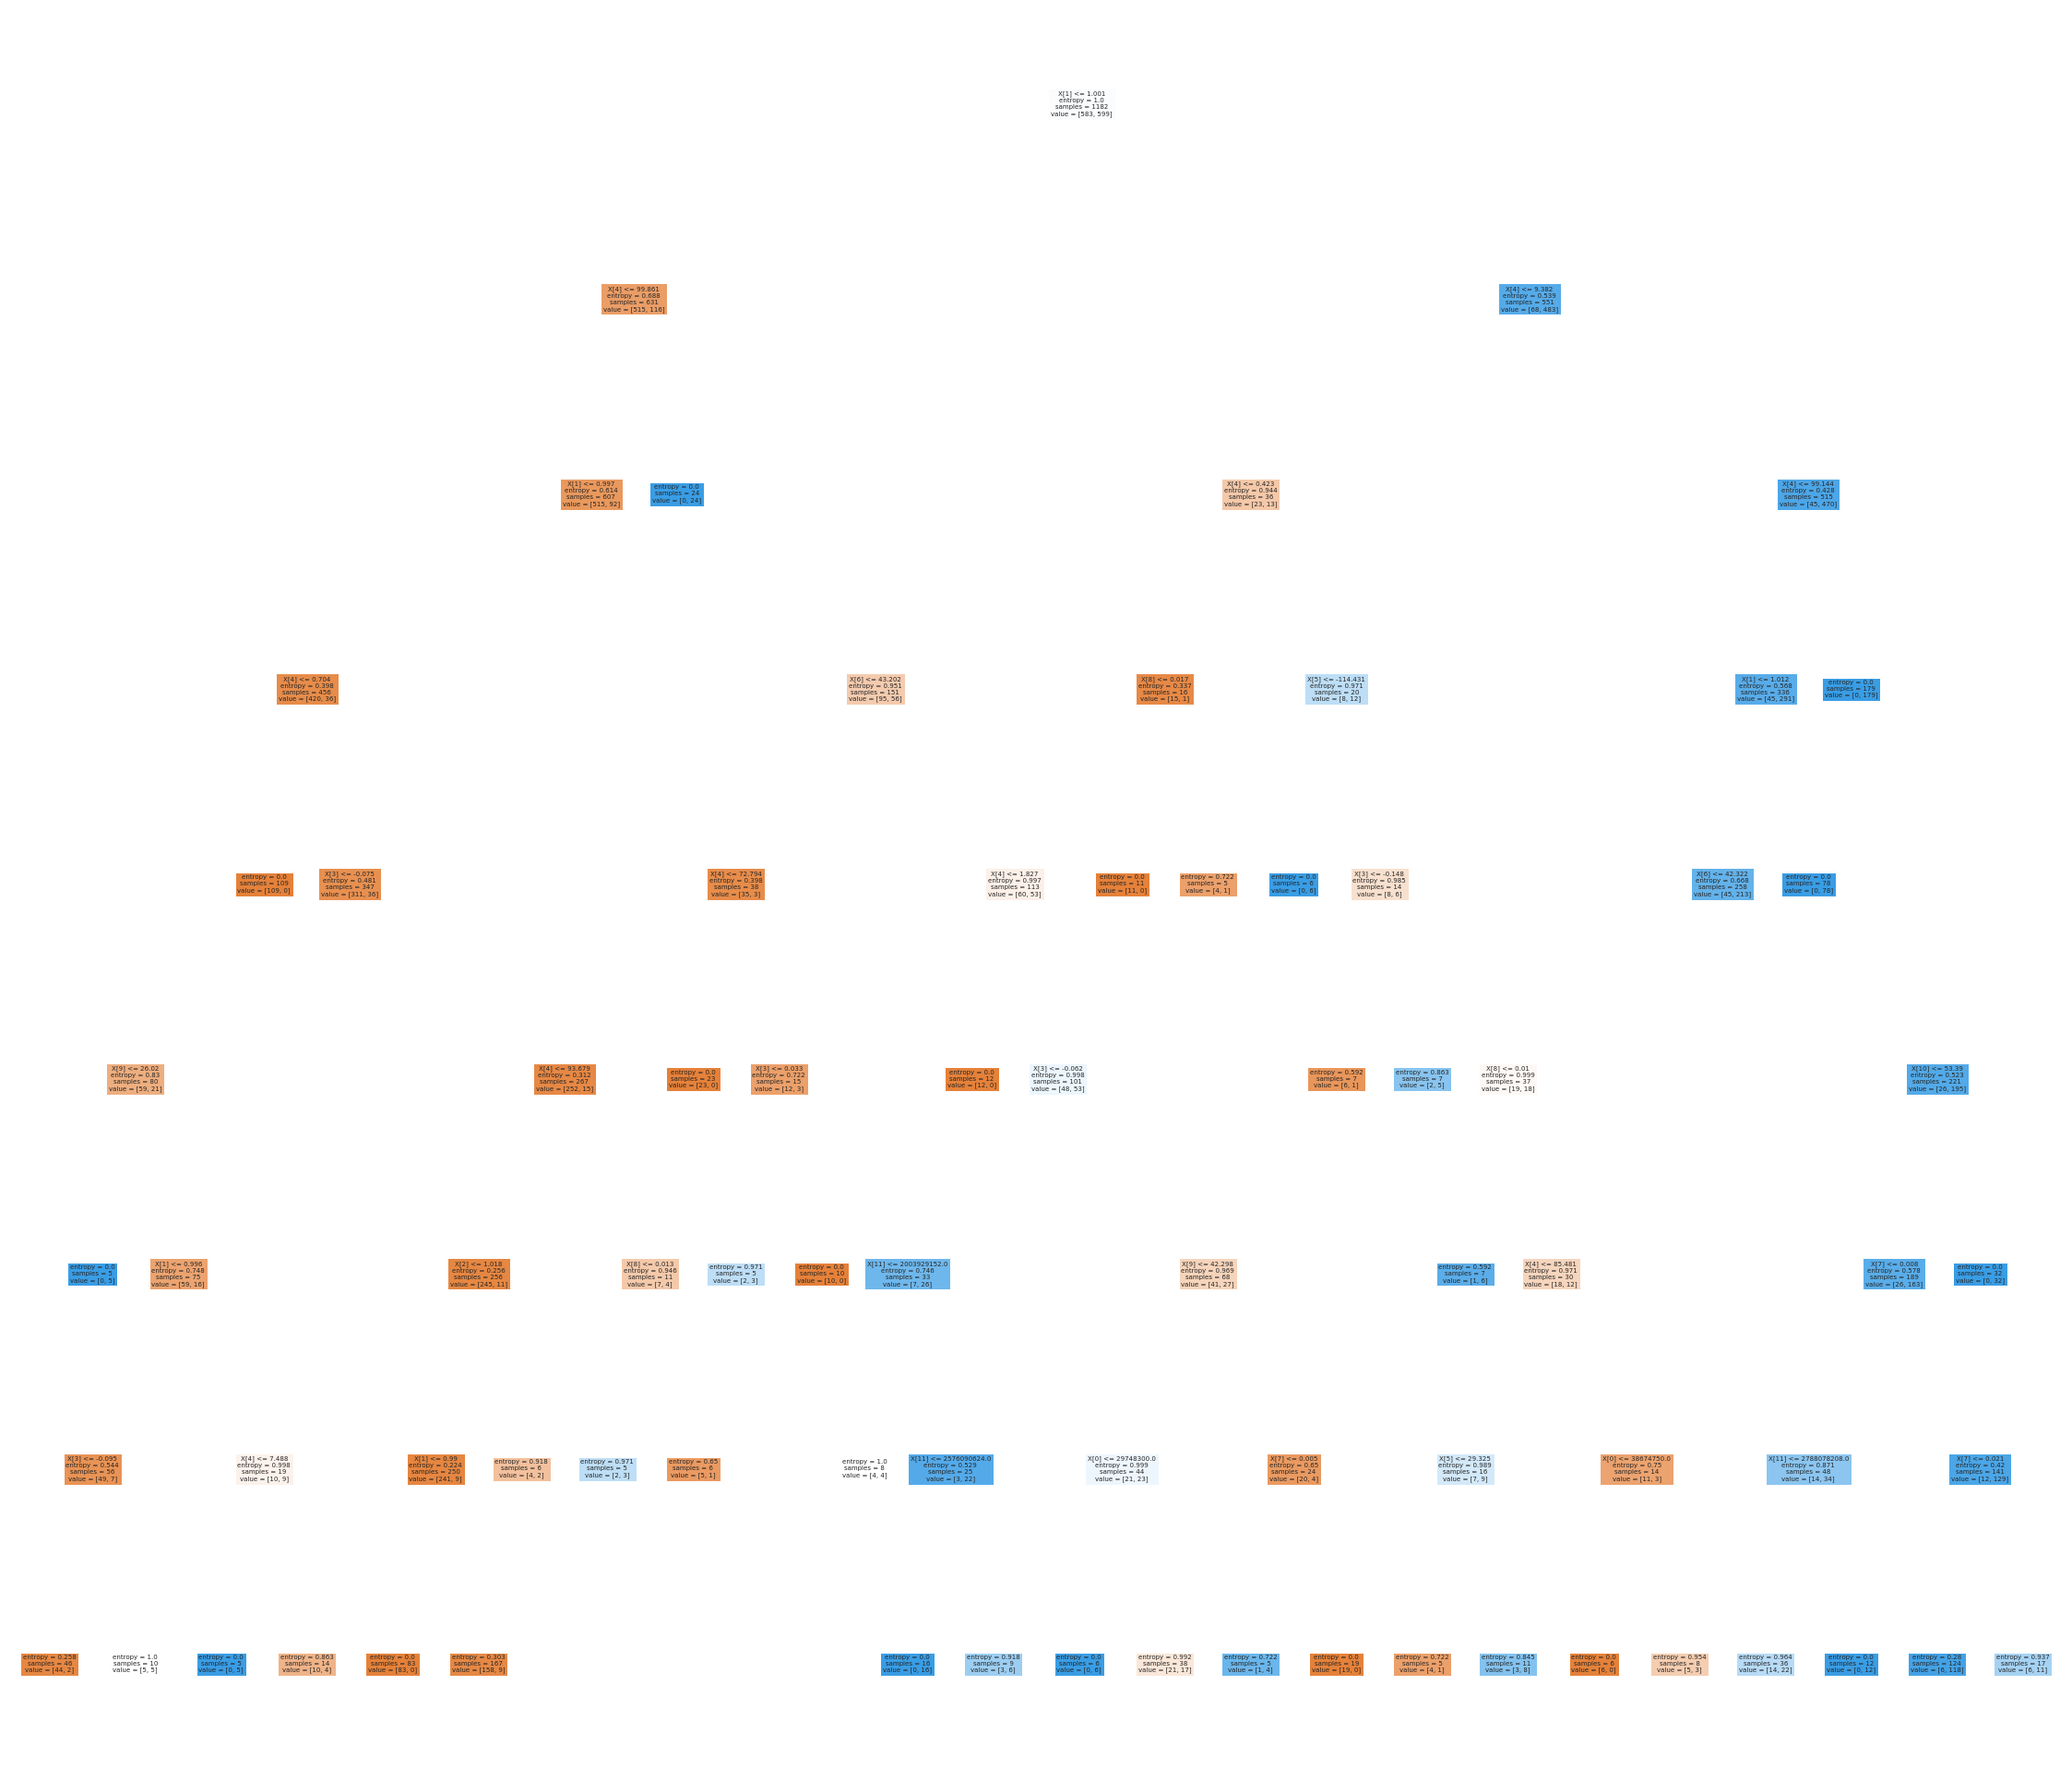

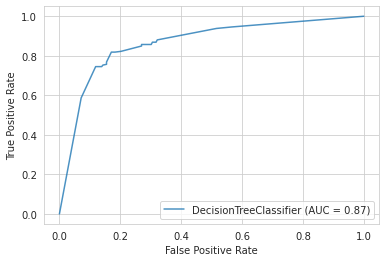

In [67]:
# Model - 2 Decision Tree

# Note: In the below code,the  Decision Tree classifier is run with and without feature selection
# For the model run with feature selection,three different feature selection techniques are used
# and the results evaluated. The outputs have indicated that Embedded technique produced better 
# accuracy when average of the 10 runs were taken

# 2.a Decision Tree with Filter method(Mutual Information)

x_train_dt = x_train[fwd_sel_columns]
x_test_dt = x_test[fwd_sel_columns]

# Calculating Entropy for training data
clf_entropy = DecisionTreeClassifier(criterion = "entropy",random_state=42, max_depth = 8, min_samples_leaf = 5)
clf_entropy.fit(x_train_dt, y_train)

# Visualizing Decision tree
plt.figure(figsize = (40,35))
tree.plot_tree(clf_entropy, filled = True)

# Text format of step by step decision tree 
print(tree.export_text(clf_entropy))
    
y_pred_en=clf_entropy.predict(x_test_dt)

# Predict probabilities for each class
prob_dt = clf_entropy.predict_proba(x_test_dt)

# Plot the roc curve
rfc_disp_curve=plot_roc_curve(clf_entropy, x_test_dt, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_dt[:,1]))

# Calculate accuracy score for selected features
print('\nAccuracy for Decision tree with Information feature selection is:',accuracy_score(y_test, y_pred_en))

# Print the classification report of the dataset using the selected feature only
print('\nClassification report:\n',classification_report(y_test, y_pred_en))


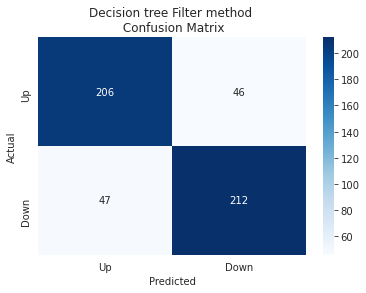

In [68]:
# Confusion Matrix
dt_cfm =confusion_matrix(y_test, y_pred_en)
sns.heatmap(dt_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Decision tree Filter method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [69]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_dt = TimeSeriesSplit(n_splits = 5)
scores_dt= cross_val_score(DecisionTreeClassifier(),x_train_dt, y_train, scoring = 'accuracy', cv = tscv_dt)
print('Cross validation score for DT using 5 Fold Split:',scores_dt)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_dt.mean())

#10 Fold
tscv_dt = TimeSeriesSplit(n_splits = 10)
scores_dt = cross_val_score(DecisionTreeClassifier(),x_train_dt, y_train, scoring = 'accuracy', cv = tscv_dt )
print('\nCross validation score for DT using 10 Fold Split:',scores_dt)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_dt.mean())

Cross validation score for DT using 5 Fold Split: [0.78172589 0.77664975 0.81725888 0.84771574 0.80203046]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8050761421319799

Cross validation score for DT using 10 Fold Split: [0.72897196 0.81308411 0.79439252 0.88785047 0.8317757  0.80373832
 0.78504673 0.81308411 0.81308411 0.86915888]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8140186915887849


|--- feature_1 <= 1.00
|   |--- feature_4 <= 99.86
|   |   |--- feature_1 <= 1.00
|   |   |   |--- feature_4 <= 0.70
|   |   |   |   |--- class: -1
|   |   |   |--- feature_4 >  0.70
|   |   |   |   |--- feature_3 <= -0.08
|   |   |   |   |   |--- feature_9 <= 26.02
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_9 >  26.02
|   |   |   |   |   |   |--- feature_1 <= 1.00
|   |   |   |   |   |   |   |--- feature_3 <= -0.09
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |   |--- feature_3 >  -0.09
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |--- feature_1 >  1.00
|   |   |   |   |   |   |   |--- feature_4 <= 7.49
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_4 >  7.49
|   |   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |--- feature_3 >  -0.08
|   |   |   |   |   |--- feature_4 <= 93.68
|   |   |   |   |   |   |--- feature_2 <= 1.02
|   |   |   |   |   |   |   |--- 

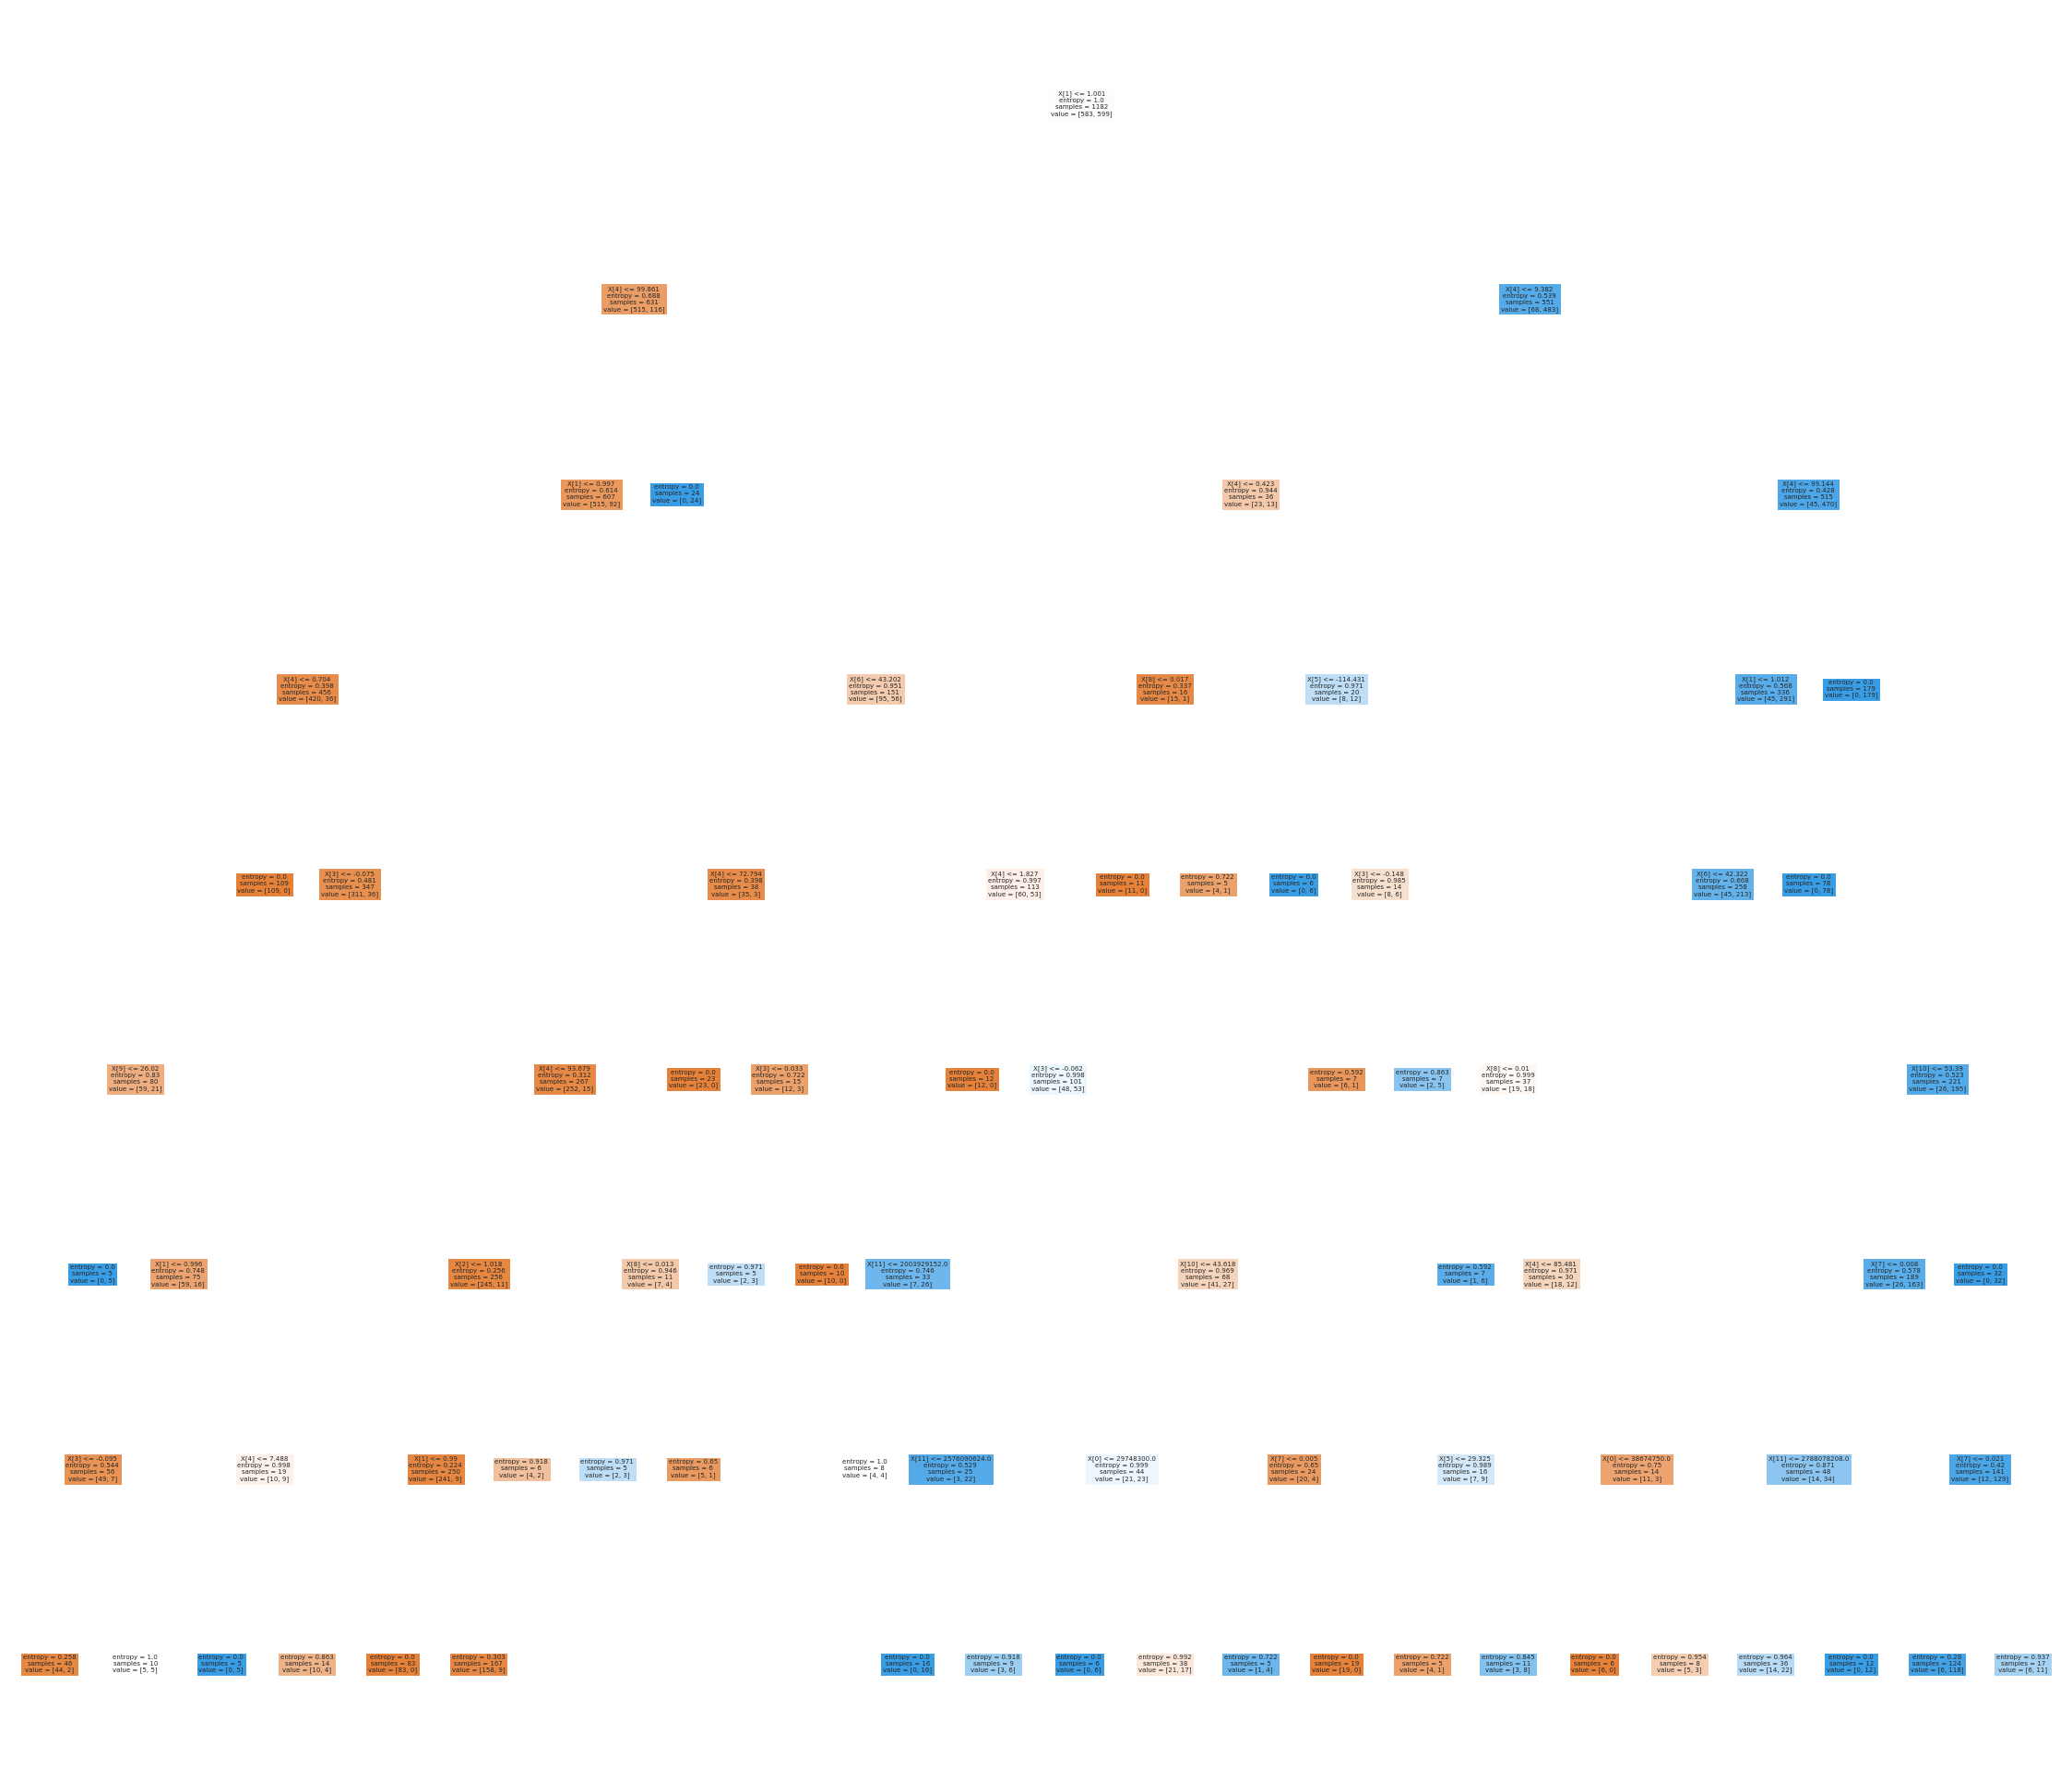

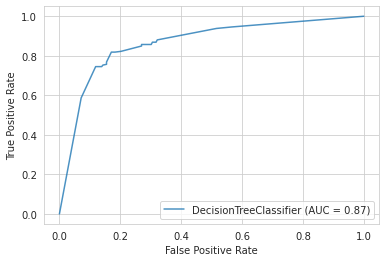

In [70]:
# Model - 2.b  Decision Tree with Wrapper method(Forward feature selection attributes)

x_train_dt1 = x_train[fwd_sel_columns]
x_test_dt1 = x_test[fwd_sel_columns]

# Calculating Entropy for training data
clf_entropy1 = DecisionTreeClassifier(criterion = "entropy",random_state=10, max_depth = 8, min_samples_leaf = 5)
clf_entropy1.fit(x_train_dt1, y_train)

# Visualizing Decision tree
plt.figure(figsize = (40,35))
tree.plot_tree(clf_entropy1, filled = True)

# Text format of step by step decision tree 
print(tree.export_text(clf_entropy1))
    
y_pred_en1=clf_entropy1.predict(x_test_dt1)

# Predict probabilities for each class
prob_dt1 = clf_entropy1.predict_proba(x_test_dt1)

# Plot the roc curve
rfc_disp_curve=plot_roc_curve(clf_entropy1, x_test_dt1, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_dt1[:,1]))


# Calculate accuracy score for selected features
print('\nAccuracy for Decision tree with Wrapper feature selection is:',accuracy_score(y_test, y_pred_en1))

# Print the classification report of the dataset using the selected feature only
print('\nClassification report:\n',classification_report(y_test, y_pred_en1))


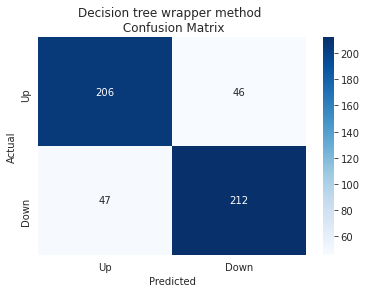

In [71]:
dt1_cfm =confusion_matrix(y_test, y_pred_en1)
sns.heatmap(dt1_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Decision tree wrapper method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [72]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_dt1 = TimeSeriesSplit(n_splits = 5)
scores_dt1= cross_val_score(DecisionTreeClassifier(),x_train_dt1, y_train, scoring = 'accuracy', cv = tscv_dt1)
print('Cross validation score for DT using 5 Fold Split:',scores_dt1)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_dt1.mean())

#10 Fold
tscv_dt1 = TimeSeriesSplit(n_splits = 10)
scores_dt1 = cross_val_score(DecisionTreeClassifier(),x_train_dt1, y_train, scoring = 'accuracy', cv = tscv_dt1 )
print('\nCross validation score for DT using 10 Fold Split:',scores_dt1)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_dt1.mean())

Cross validation score for DT using 5 Fold Split: [0.80203046 0.81218274 0.78172589 0.84771574 0.8071066 ]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8101522842639592

Cross validation score for DT using 10 Fold Split: [0.72897196 0.76635514 0.79439252 0.8317757  0.8317757  0.8317757
 0.80373832 0.81308411 0.79439252 0.8411215 ]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8037383177570094


|--- feature_11 <= 1.00
|   |--- feature_9 <= 99.86
|   |   |--- feature_11 <= 1.00
|   |   |   |--- feature_9 <= 0.70
|   |   |   |   |--- class: -1
|   |   |   |--- feature_9 >  0.70
|   |   |   |   |--- feature_5 <= -0.08
|   |   |   |   |   |--- feature_9 <= 2.87
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_9 >  2.87
|   |   |   |   |   |   |--- feature_10 <= 1.00
|   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |--- feature_10 >  1.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_5 >  -0.08
|   |   |   |   |   |--- feature_9 <= 93.68
|   |   |   |   |   |   |--- feature_10 <= 1.00
|   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |--- feature_10 >  1.00
|   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |--- feature_9 >  93.68
|   |   |   |   |   |   |--- feature_2 <= 0.02
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_2 >  0.02
|   |   |   |   |   |   

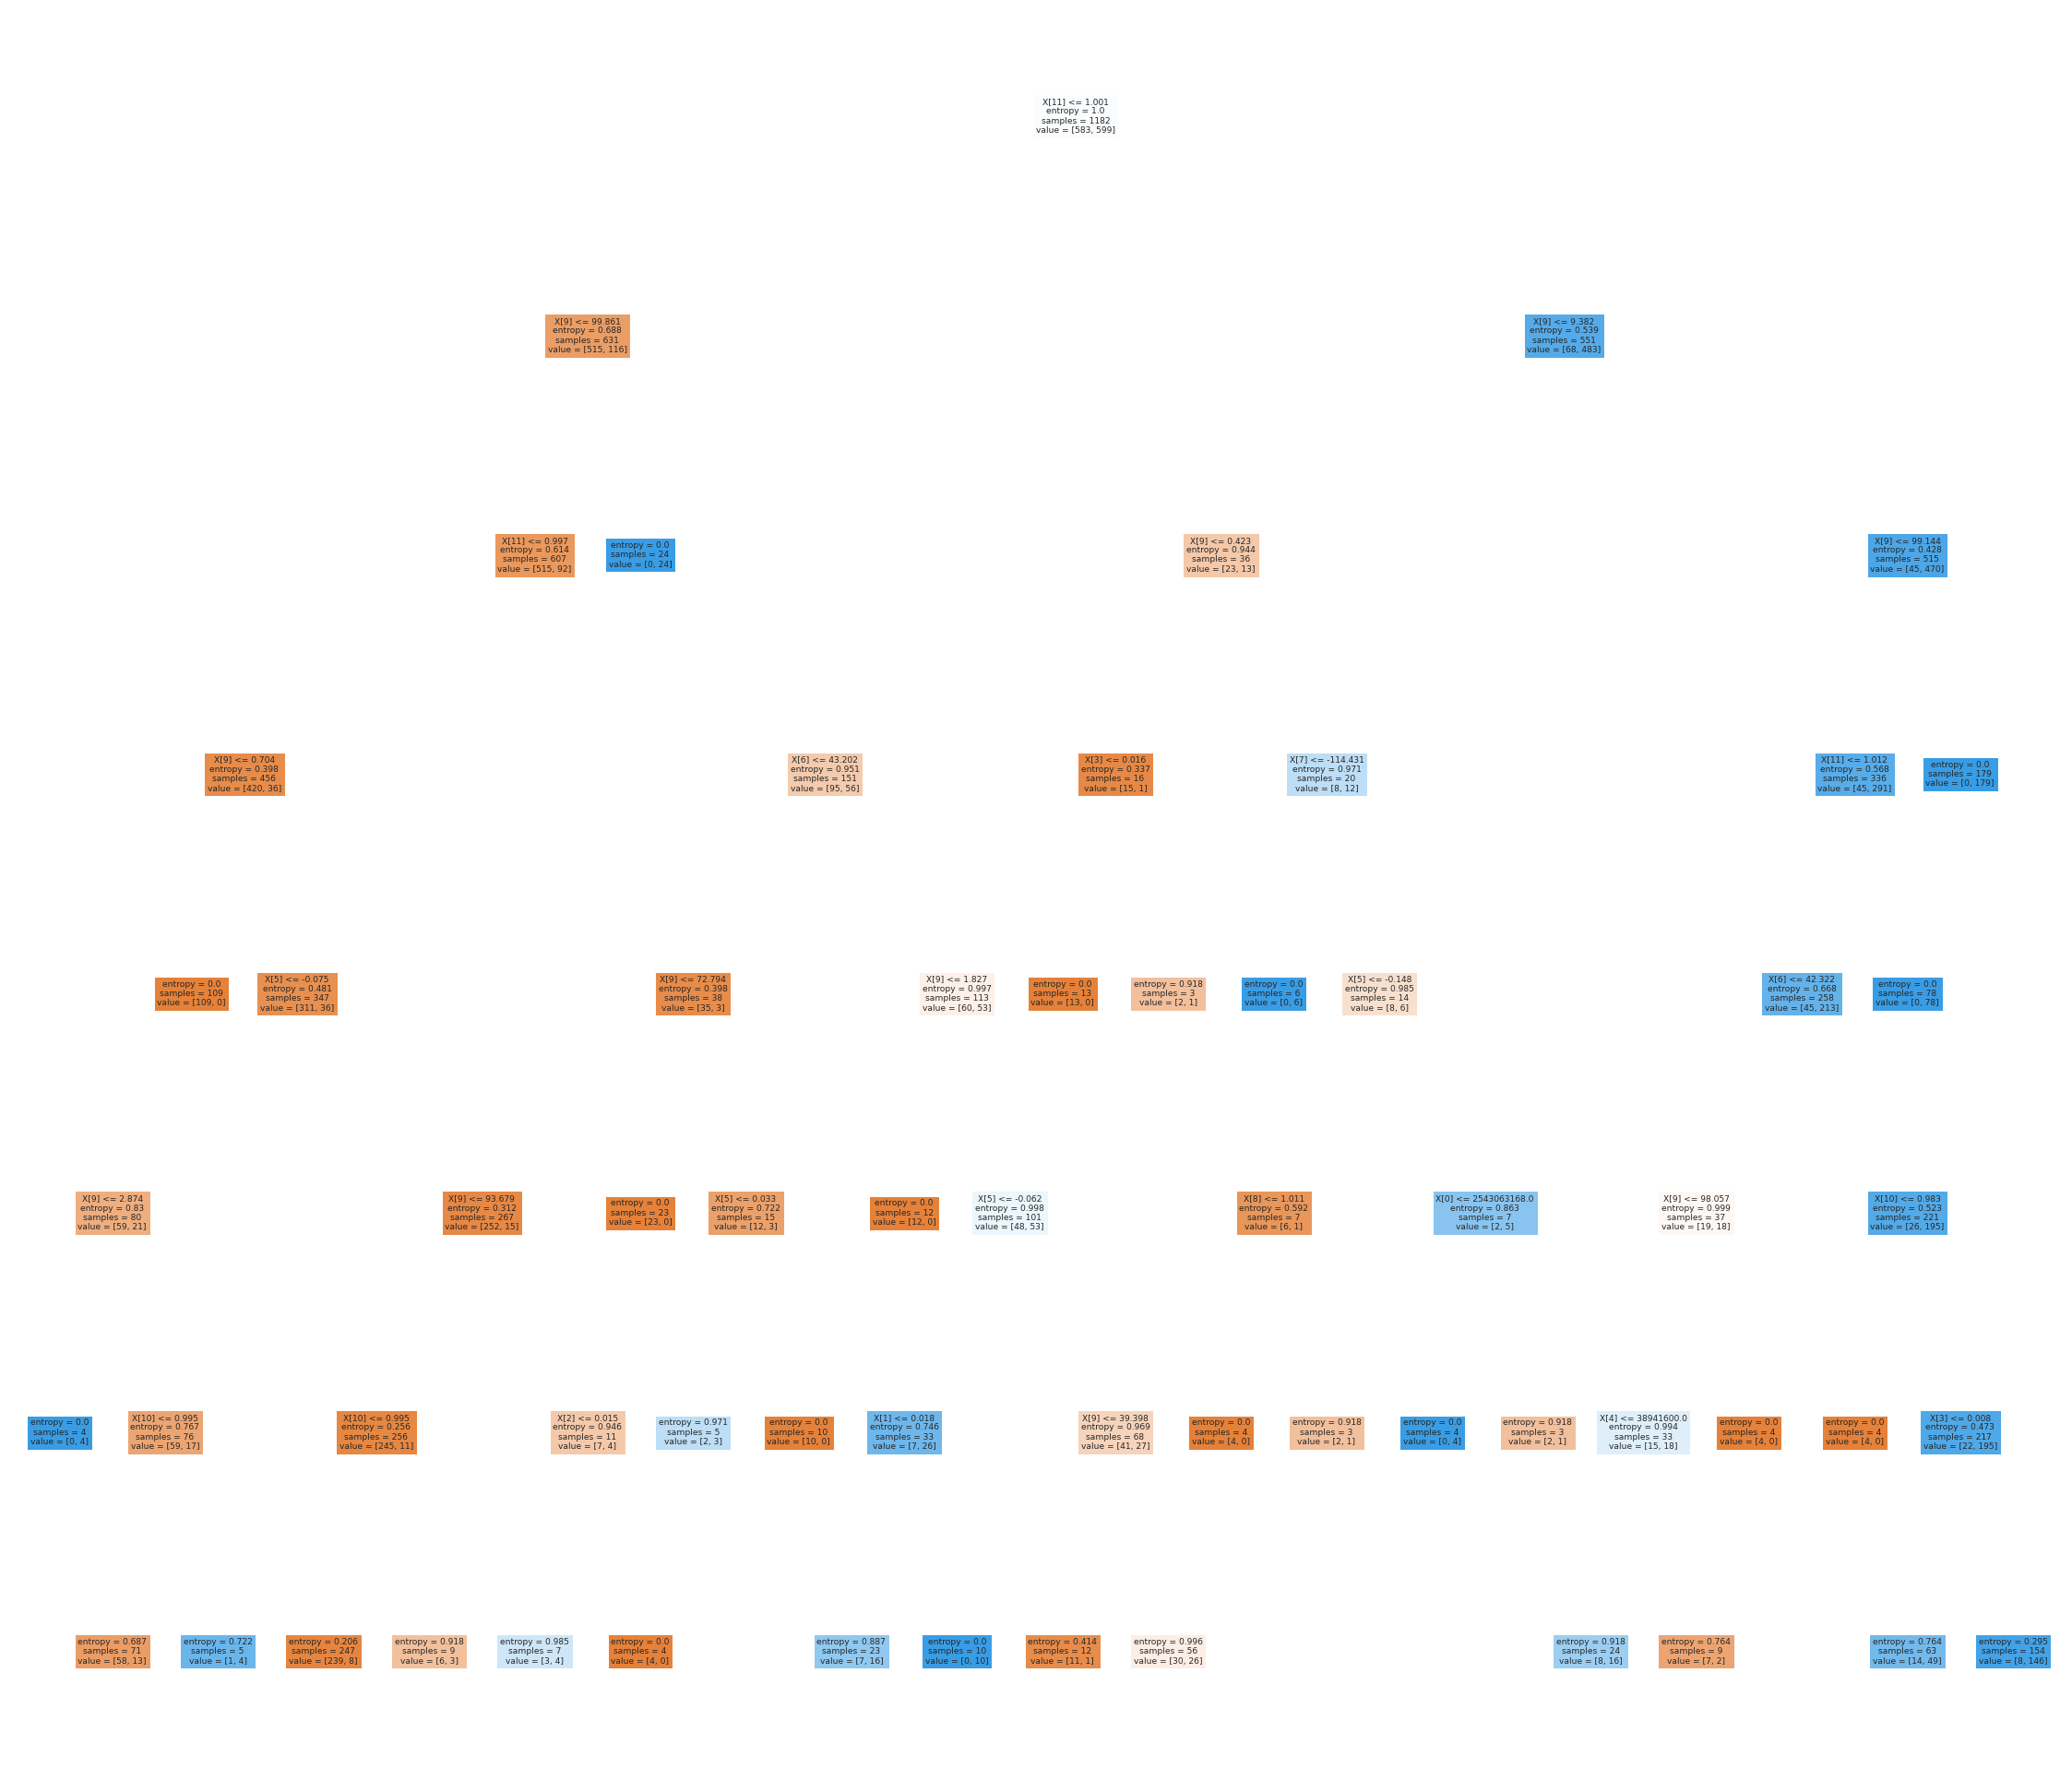

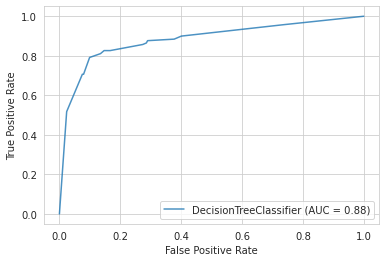

In [73]:
# Model- 2.c Decision Tree with Embadded method (Tree based feature selection attributes)

x_train_dt2 = x_train[tree_sel_columns]
x_test_dt2 = x_test[tree_sel_columns]

# Calculating Entropy for training data
clf_entropy2 = DecisionTreeClassifier(criterion = "entropy",random_state=2, max_depth = 7, min_samples_leaf = 3)
clf_entropy2.fit(x_train_dt2, y_train)

# Visualizing Decision tree
plt.figure(figsize = (40,35))
tree.plot_tree(clf_entropy2, filled = True)

# Text format of step by step decision tree 
print(tree.export_text(clf_entropy2))
    
y_pred_en2=clf_entropy2.predict(x_test_dt2)

# Predict probabilities for each class
prob_dt2 = clf_entropy2.predict_proba(x_test_dt2)

# Plot the roc curve
rfc_disp_curve=plot_roc_curve(clf_entropy2, x_test_dt2, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_dt2[:,1]))

# Calculate accuracy score for selected features
print('\nAccuracy for Decision tree with embadded feature selection is:',accuracy_score(y_test, y_pred_en2))

# Print the classification report of the dataset using the selected feature only
print('\nClassification report:\n',classification_report(y_test, y_pred_en2))



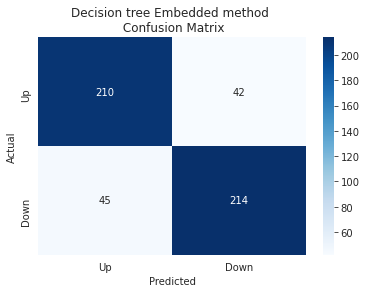

In [74]:
#Confusion Matrix
dt2_cfm =confusion_matrix(y_test, y_pred_en2)
sns.heatmap(dt2_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Decision tree Embedded method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [75]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_dt2 = TimeSeriesSplit(n_splits = 5)
scores_dt2= cross_val_score(DecisionTreeClassifier(),x_train_dt2, y_train, scoring = 'accuracy', cv = tscv_dt2)
print('Cross validation score for DT using 5 Fold Split:',scores_dt2)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_dt2.mean())

#10 Fold
tscv_dt2 = TimeSeriesSplit(n_splits = 10)
scores_dt2 = cross_val_score(DecisionTreeClassifier(),x_train_dt2, y_train, scoring = 'accuracy', cv = tscv_dt2 )
print('\nCross validation score for DT using 10 Fold Split:',scores_dt2)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_dt2.mean())

Cross validation score for DT using 5 Fold Split: [0.7715736  0.85279188 0.81218274 0.81218274 0.78172589]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8060913705583757

Cross validation score for DT using 10 Fold Split: [0.75700935 0.78504673 0.79439252 0.87850467 0.78504673 0.82242991
 0.8317757  0.81308411 0.75700935 0.82242991]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8046728971962616


|--- feature_8 <= 1.00
|   |--- feature_13 <= 99.86
|   |   |--- feature_8 <= 1.00
|   |   |   |--- feature_13 <= 0.70
|   |   |   |   |--- class: -1
|   |   |   |--- feature_13 >  0.70
|   |   |   |   |--- feature_12 <= -0.08
|   |   |   |   |   |--- feature_5 <= 26.02
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_5 >  26.02
|   |   |   |   |   |   |--- feature_13 <= 2.87
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_13 >  2.87
|   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |--- feature_12 >  -0.08
|   |   |   |   |   |--- feature_13 <= 93.68
|   |   |   |   |   |   |--- feature_9 <= 1.00
|   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |   |--- feature_9 >  1.00
|   |   |   |   |   |   |   |--- class: -1
|   |   |   |   |   |--- feature_13 >  93.68
|   |   |   |   |   |   |--- feature_17 <= 0.02
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_17 >  0.02
|   |   |   |   |

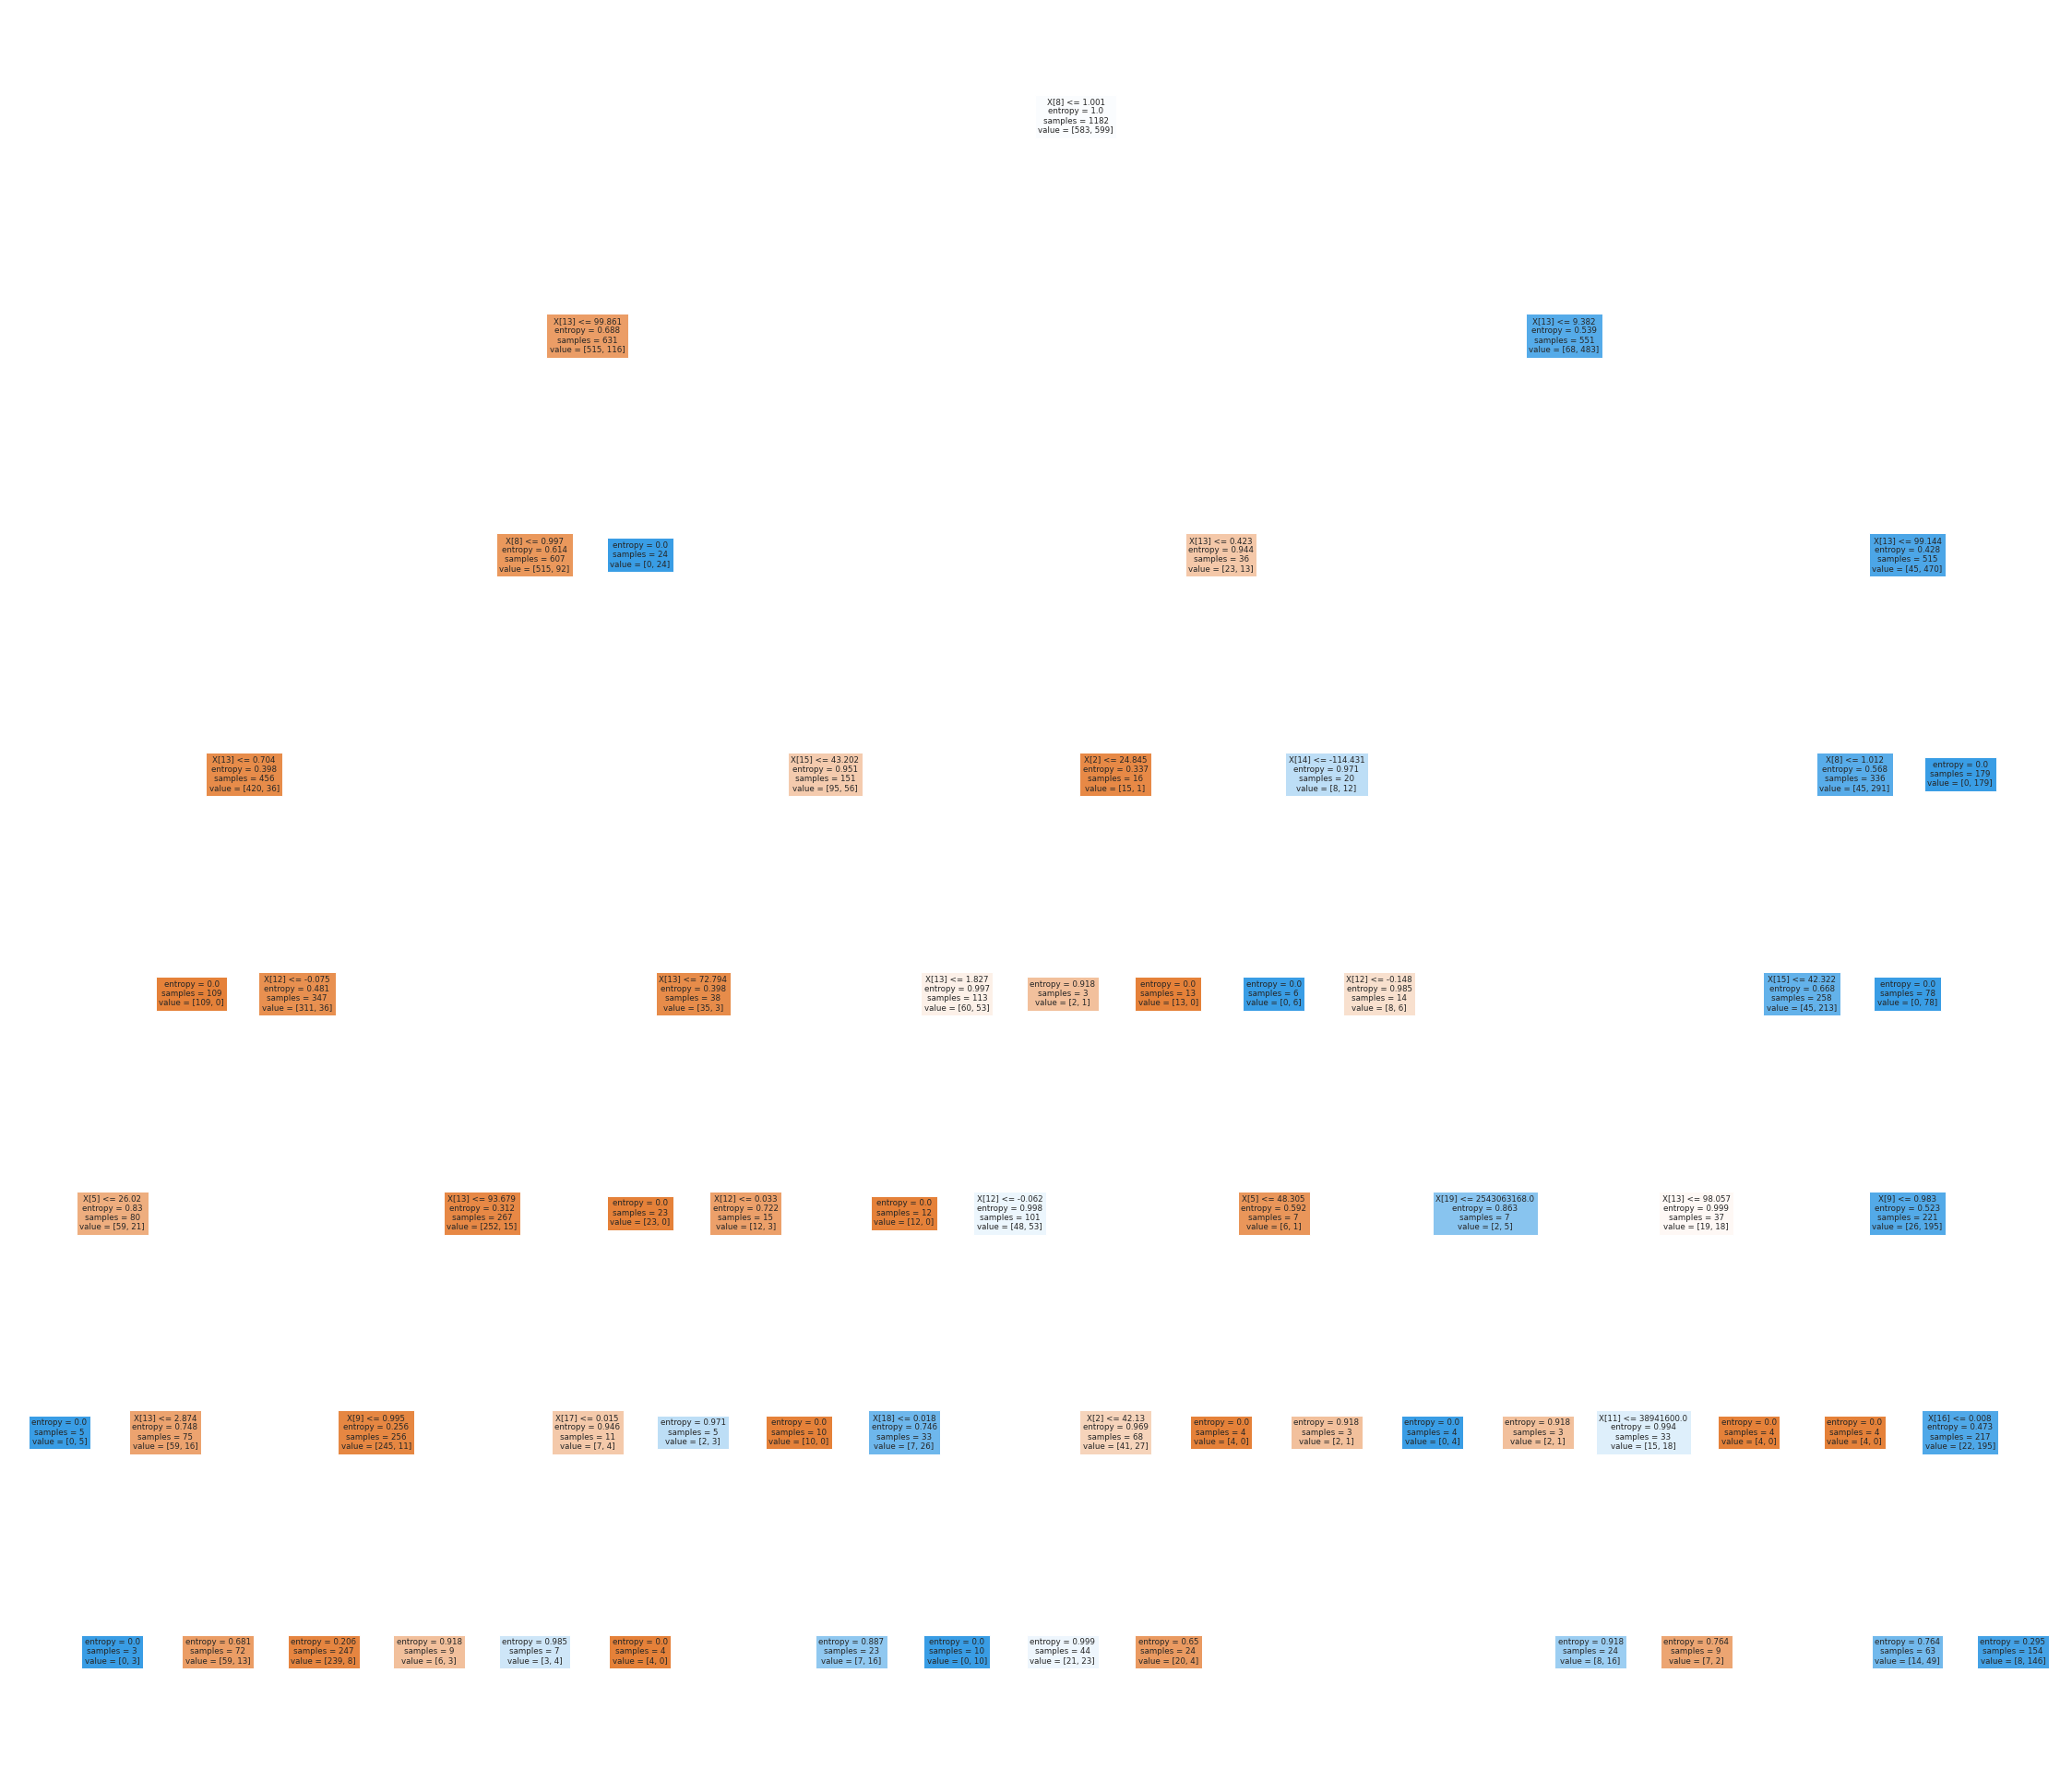

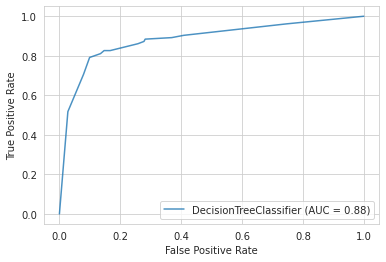

In [76]:
# Model-2.d Decision Tree Model without feature selection 

x_train_dt3 = x_train[['open','close','low','high','ma_50d','middle_band','upper_band','lower_band','close_to_open',\
                       'close_to_high','close_to_low', 'volume', 'macd_diff','stochastic_osci', 'cci', 'rsi', '5d_volatility',\
                       '21d_volatility', '60d_volatility', 'on_balance_volume']]
x_test_dt3 = x_test[['open','close','low','high','ma_50d','middle_band','upper_band','lower_band','close_to_open',\
                     'close_to_high','close_to_low', 'volume', 'macd_diff','stochastic_osci', 'cci', 'rsi', '5d_volatility',\
                     '21d_volatility', '60d_volatility', 'on_balance_volume']]
# Calculating Entropy for training data
clf_entropy3 = DecisionTreeClassifier(criterion = "entropy",random_state=100, max_depth = 7, min_samples_leaf = 3)
clf_entropy3.fit(x_train_dt3, y_train)

# Visualizing Decision tree
plt.figure(figsize = (40,35))
tree.plot_tree(clf_entropy3, filled = True)

# Text format of step by step decision tree 
print(tree.export_text(clf_entropy3))
    
y_pred_en3=clf_entropy3.predict(x_test_dt3)

# Predict probabilities for each class
prob_dt3 = clf_entropy3.predict_proba(x_test_dt3)

# Plot the roc curve
rfc_disp_curve=plot_roc_curve(clf_entropy3, x_test_dt3, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_dt3[:,1]))

# Calculate accuracy score for selected features
print('\nAccuracy for Decision tree without feature selection is:',accuracy_score(y_test, y_pred_en3))

# Print the classification report of the dataset using the selected feature only
print('\nClassification report:\n',classification_report(y_test, y_pred_en3))



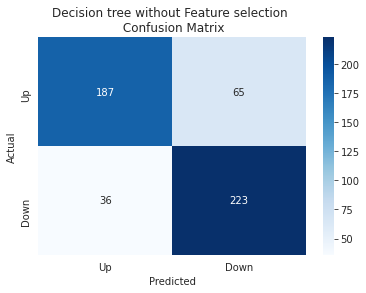

In [77]:
#Confustion Matrix
dt3_cfm =confusion_matrix(y_test, y_pred_en3)
sns.heatmap(dt3_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Decision tree without Feature selection \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [78]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_dt3 = TimeSeriesSplit(n_splits = 5)
scores_dt3= cross_val_score(DecisionTreeClassifier(),x_train_dt3, y_train, scoring = 'accuracy', cv = tscv_dt3)
print('Cross validation score for DT using 5 Fold Split:',scores_dt3)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_dt3.mean())

# 10 Fold
tscv_dt3 = TimeSeriesSplit(n_splits = 10)
scores_dt3 = cross_val_score(DecisionTreeClassifier(),x_train_dt3, y_train, scoring = 'accuracy', cv = tscv_dt3 )
print('\nCross validation score for DT using 10 Fold Split:',scores_dt3)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_dt3.mean())

Cross validation score for DT using 5 Fold Split: [0.78172589 0.83248731 0.80203046 0.83756345 0.78680203]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8081218274111676

Cross validation score for DT using 10 Fold Split: [0.75700935 0.80373832 0.73831776 0.86915888 0.79439252 0.8411215
 0.79439252 0.85046729 0.77570093 0.8411215 ]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8065420560747663


ROC AUC score: 0.9159618802475946

Accuracy for SVM with Filter feature selection is: 0.8454011741682974

Classification report:
               precision    recall  f1-score   support

          -1       0.84      0.85      0.84       252
           1       0.85      0.84      0.85       259

    accuracy                           0.85       511
   macro avg       0.85      0.85      0.85       511
weighted avg       0.85      0.85      0.85       511



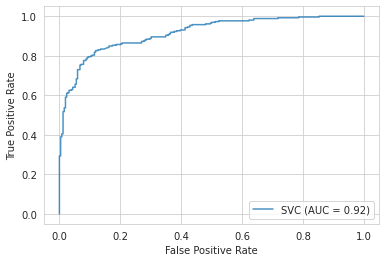

In [79]:
# support vector machine

# Note: In the below code,the  Support Vector Machine is run with and without feature selection
# For the model run with feature selection,three different feature selection techniques are used
# and the results evaluated. The outputs have indicated that accuracy was better for the average of 10 runs
# when no  Feature selection was done

# Model - 3.a SVM with Filter method (Mutual Information) 

x_train_svc = x_train[mi_columns]
x_test_svc = x_test[mi_columns]

# For improving the execution speed
x_train_svc=sklearn_preprocessing.scale(x_train_svc)
x_test_svc=sklearn_preprocessing.scale(x_test_svc) 

clf_svc=SVC(kernel = 'linear', C= 2, probability = True)
clf_svc.fit(x_train_svc, y_train)

y_pred_svc=clf_svc.predict(x_test_svc)
                           
# Predict probabilities for each class
prob_svc= clf_svc.predict_proba(x_test_svc)

# Plot the roc curve
svc_disp_curve=plot_roc_curve(clf_svc, x_test_svc, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_svc[:,1]))


# Calculate accuracy score for selected features
print('\nAccuracy for SVM with Filter feature selection is:',accuracy_score(y_test, y_pred_svc))

# Print the classification report of the dataset using the selected feature only                         
print('\nClassification report:\n',classification_report(y_test, y_pred_svc))

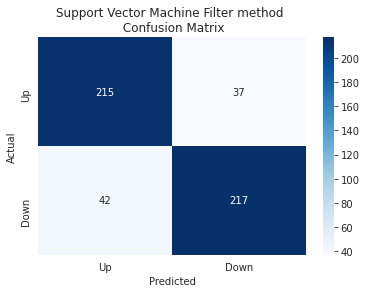

In [80]:
#Confusion Matrix
svc_cfm =confusion_matrix(y_test, y_pred_svc)
sns.heatmap(svc_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Support Vector Machine Filter method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [81]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_svc = TimeSeriesSplit(n_splits = 5)
scores_svc= cross_val_score(SVC(),x_train_svc, y_train, scoring = 'accuracy', cv = tscv_svc)
print('Cross validation score for SVM using 5 Fold Split:',scores_svc)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_svc.mean())

# 10 fold
tscv_svc = TimeSeriesSplit(n_splits = 10)
scores_svc = cross_val_score(SVC(),x_train_svc, y_train, scoring = 'accuracy', cv = tscv_svc)
print('\nCross validation score for SVM using 10 Fold Split:',scores_svc)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_svc.mean())

Cross validation score for SVM using 5 Fold Split: [0.79187817 0.89847716 0.84771574 0.86294416 0.82741117]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8456852791878173

Cross validation score for SVM using 10 Fold Split: [0.82242991 0.79439252 0.82242991 0.87850467 0.89719626 0.85046729
 0.88785047 0.8411215  0.82242991 0.85046729]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.846728971962617


ROC AUC score: 0.9268860697432126

Accuracy for SVM with wrapper feature selection is: 0.8473581213307241

Classification report:
               precision    recall  f1-score   support

          -1       0.86      0.83      0.84       252
           1       0.84      0.87      0.85       259

    accuracy                           0.85       511
   macro avg       0.85      0.85      0.85       511
weighted avg       0.85      0.85      0.85       511



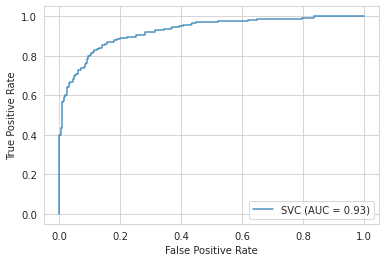

In [82]:
# Model - 3.b support vector machine with Wrapper Method (Forward feature selection)

x_train_svc1 = x_train[fwd_sel_columns]
x_test_svc1 = x_test[fwd_sel_columns]

# For improving the execution speed
x_train_svc1=sklearn_preprocessing.scale(x_train_svc1)
x_test_svc1=sklearn_preprocessing.scale(x_test_svc1) 



clf_svc1=SVC(kernel = 'linear', gamma = 'auto', C= 2, probability = True)
clf_svc1.fit(x_train_svc1, y_train)
y_pred_svc1=clf_svc1.predict(x_test_svc1)

# Predict probabilities for each class
prob_svc1= clf_svc1.predict_proba(x_test_svc1)

# Plot the roc curve
svc_disp_curve=plot_roc_curve(clf_svc1, x_test_svc1, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_svc1[:,1]))


# Calculate accuracy score for selected features
print('\nAccuracy for SVM with wrapper feature selection is:',accuracy_score(y_test, y_pred_svc1))

# Print the classification report of the dataset using the selected feature only                         
print('\nClassification report:\n',classification_report(y_test, y_pred_svc1))


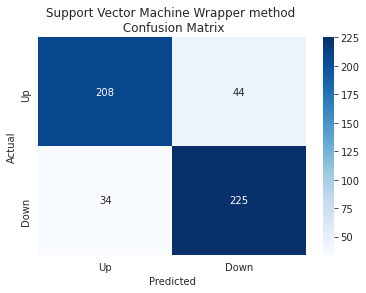

In [83]:
#Confusion Matrix
svc1_cfm =confusion_matrix(y_test, y_pred_svc1)
sns.heatmap(svc1_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Support Vector Machine Wrapper method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [84]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_svc1 = TimeSeriesSplit(n_splits = 5)
scores_svc1= cross_val_score(SVC(),x_train_svc1, y_train, scoring = 'accuracy', cv = tscv_svc1)
print('Cross validation score for SVM using 5 Fold Split:',scores_svc1)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_svc1.mean())

#10 Fold
tscv_svc1 = TimeSeriesSplit(n_splits = 10)
scores_svc1 = cross_val_score(SVC(),x_train_svc1, y_train, scoring = 'accuracy', cv = tscv_svc1)
print('\nCross validation score for SVM using 10 Fold Split:',scores_svc1)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_svc1.mean())

Cross validation score for SVM using 5 Fold Split: [0.82233503 0.91370558 0.83756345 0.87309645 0.82233503]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8538071065989847

Cross validation score for SVM using 10 Fold Split: [0.77570093 0.82242991 0.8317757  0.90654206 0.90654206 0.8411215
 0.89719626 0.85046729 0.8411215  0.80373832]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8476635514018692


ROC AUC score: 0.9250015321443893

Accuracy for SVM with embadded feature selection is: 0.8493150684931506

Classification report:
               precision    recall  f1-score   support

          -1       0.85      0.84      0.85       252
           1       0.84      0.86      0.85       259

    accuracy                           0.85       511
   macro avg       0.85      0.85      0.85       511
weighted avg       0.85      0.85      0.85       511



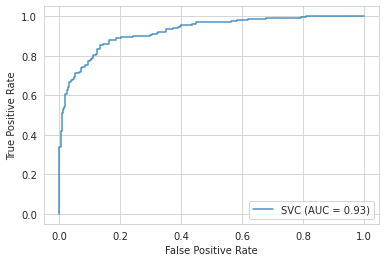

In [85]:
# Model 3.c Suport vector Machine with Embedded Method (Tree based)

x_train_svc2 = x_train[tree_sel_columns]
x_test_svc2 = x_test[tree_sel_columns]
# for improving the execution speed
x_train_svc2=sklearn_preprocessing.scale(x_train_svc2)
x_test_svc2=sklearn_preprocessing.scale(x_test_svc2) 

#kernel coefficient 
#current default is 'auto which usees (1/n features)

clf_svc2=SVC(kernel = 'linear', gamma = 'auto', C= 2, probability = True)
clf_svc2.fit(x_train_svc2, y_train)
y_pred_svc2=clf_svc2.predict(x_test_svc2)

# Predict probabilities for each class
prob_svc2= clf_svc2.predict_proba(x_test_svc2)

# Plot the roc curve
svc_disp_curve=plot_roc_curve(clf_svc2, x_test_svc2, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_svc2[:,1]))


# Calculate accuracy score for selected features
print('\nAccuracy for SVM with embadded feature selection is:',accuracy_score(y_test, y_pred_svc2))

# Print the classification report of the dataset using the selected feature only                         
print('\nClassification report:\n',classification_report(y_test, y_pred_svc2))



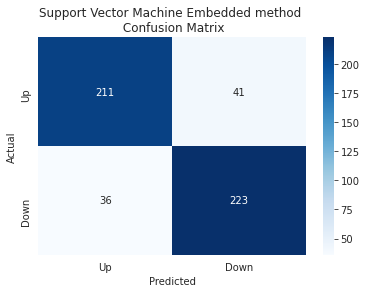

In [86]:
#Confusion Matrix
svc2_cfm =confusion_matrix(y_test, y_pred_svc2)
sns.heatmap(svc2_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Support Vector Machine Embedded method \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_svc2 = TimeSeriesSplit(n_splits = 5)
scores_svc2= cross_val_score(SVC(),x_train_svc2, y_train, scoring = 'accuracy', cv = tscv_svc2)
print('Cross validation score for SVM using 5 Fold Split:',scores_svc2)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_svc2.mean())

#10 Fold
tscv_svc2 = TimeSeriesSplit(n_splits = 10)
scores_svc2 = cross_val_score(SVC(),x_train_svc2, y_train, scoring = 'accuracy', cv = tscv_svc2)
print('\nCross validation score for SVM using 10 Fold Split:',scores_svc2)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_svc2.mean())

Cross validation score for SVM using 5 Fold Split: [0.82741117 0.9035533  0.84771574 0.87817259 0.81725888]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8548223350253809

Cross validation score for SVM using 10 Fold Split: [0.77570093 0.82242991 0.8411215  0.87850467 0.93457944 0.81308411
 0.89719626 0.85046729 0.8411215  0.81308411]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.846728971962617


ROC AUC score: 0.9279892137034994

Accuracy for SVM without feature selection is: 0.8551859099804305

Classification report:
               precision    recall  f1-score   support

          -1       0.86      0.84      0.85       252
           1       0.85      0.87      0.86       259

    accuracy                           0.86       511
   macro avg       0.86      0.85      0.86       511
weighted avg       0.86      0.86      0.86       511



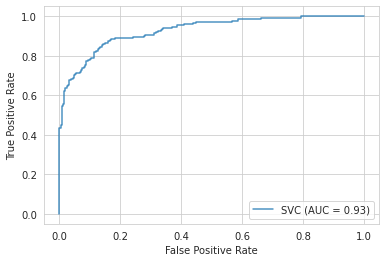

In [88]:
# Model - 3.d SVM without feature selection

x_train_svc3 = x_train[['open','close','low','high','ma_50d','middle_band','upper_band','lower_band','close_to_open',\
                       'close_to_high','close_to_low', 'volume', 'macd_diff','stochastic_osci', 'cci', 'rsi', '5d_volatility',\
                       '21d_volatility', '60d_volatility', 'on_balance_volume']]
x_test_svc3 = x_test[['open','close','low','high','ma_50d','middle_band','upper_band','lower_band','close_to_open',\
                     'close_to_high','close_to_low', 'volume', 'macd_diff','stochastic_osci', 'cci', 'rsi', '5d_volatility',\
                     '21d_volatility', '60d_volatility', 'on_balance_volume']]
# for improving the execution speed
x_train_svc3=sklearn_preprocessing.scale(x_train_svc3)
x_test_svc3=sklearn_preprocessing.scale(x_test_svc3) 

#kernel coefficient 
#current default is 'auto which usees (1/n features)

clf_svc3=SVC(kernel = 'linear', gamma = 'auto', C=2, probability = True)
clf_svc3.fit(x_train_svc3, y_train)
y_pred_svc3=clf_svc3.predict(x_test_svc3)

# Predict probabilities for each class
prob_svc3= clf_svc3.predict_proba(x_test_svc3)

# Plot the roc curve
svc_disp_curve=plot_roc_curve(clf_svc3, x_test_svc3, y_test, alpha = 0.8)

# Calculate Roc AUC score using important features
print('ROC AUC score:', roc_auc_score(y_test, prob_svc3[:,1]))


# Calculate accuracy score for selected features
print('\nAccuracy for SVM without feature selection is:',accuracy_score(y_test, y_pred_svc3))

# Print the classification report of the dataset using the selected feature only                         
print('\nClassification report:\n',classification_report(y_test, y_pred_svc3))


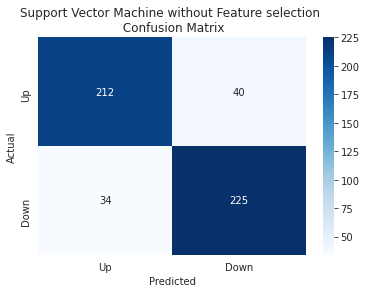

In [89]:
#Confusion Matrix
svc3_cfm =confusion_matrix(y_test, y_pred_svc3)
sns.heatmap(svc3_cfm, xticklabels = ['Up','Down'], yticklabels = ['Up','Down'], annot = True, cmap = 'Blues', fmt = 'd')
plt.axes().set_title("Support Vector Machine without Feature selection \n Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [90]:
# Cross validation 
# Split data using TimeSeriesSplit

# 5 Fold
tscv_svc3 = TimeSeriesSplit(n_splits = 5)
scores_svc3= cross_val_score(SVC(),x_train_svc3, y_train, scoring = 'accuracy', cv = tscv_svc3)
print('Cross validation score for SVM using 5 Fold Split:',scores_svc3)
print('Mean Accuracy from Cross Validation for 5 Fold Split:',scores_svc3.mean())

#10 Fold
tscv_svc3 = TimeSeriesSplit(n_splits = 10)
scores_svc3 = cross_val_score(SVC(),x_train_svc3, y_train, scoring = 'accuracy', cv = tscv_svc3)
print('\nCross validation score for SVM using 10 Fold Split:',scores_svc3)
print('Mean Accuracy from Cross Validation for 10 Fold Split:',scores_svc3.mean())

Cross validation score for SVM using 5 Fold Split: [0.81218274 0.88832487 0.85279188 0.85786802 0.8071066 ]
Mean Accuracy from Cross Validation for 5 Fold Split: 0.8436548223350254

Cross validation score for SVM using 10 Fold Split: [0.78504673 0.80373832 0.85046729 0.87850467 0.89719626 0.8411215
 0.87850467 0.8411215  0.8317757  0.80373832]
Mean Accuracy from Cross Validation for 10 Fold Split: 0.8411214953271028
